# Spaceship Titanic

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

In [1]:
# импортируем библиотеки

from pathlib import Path

import pandas as pd
import numpy as np
import optuna

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_roc_curve

In [2]:
# Функция для открытия файлов

def open_file(name):
    try:
        my_csv = Path("C:/Users/Счастливый/Desktop/project/spaceship-titanic/" + name)
        return pd.read_csv(my_csv.resolve(), sep=',').copy()
    except:
        return print('File not found...')

Откроем все файлы.

In [3]:
titanic_train = open_file('train.csv')
titanic_train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [4]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
titanic_test = open_file('test.csv')
titanic_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


In [6]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [7]:
submission = open_file('sample_submission.csv')

In [8]:
submission.head(3)

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False


* Открыли все файлы;
* Проверили на первый взгляд правильность прочтения;
* Есть пропуски;
* Видим в тестовом файле отсутствие целевого признака;
* Посмотрели пример отправки файла предсказанных ответов.

Проведем последовательно исследовательский анализ и первичную подготовку данных.

## Исследовательский анализ

* Последовательно изучим `titanic_train` и сделаем необходимые первичные преобразования.
* После то же самое применим к `titanic_test`.

In [9]:
# Добавим в список наши датасеты

titanic = [titanic_train, titanic_test]

In [10]:
titanic_train.isna().mean()

PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
dtype: float64

Пропуски везде примерно 2%, кроме `PassengerId` и `Transported`. Переведем наименования столбцов в `snake_case`.

In [11]:
# функция для преобразования названий столбцов из CamelCase в snake_case
def camel_to_snake(data):
    col = []
    for row in data.columns:
        index = [i for i, c in enumerate(row) if c.isupper()]
        count = -1
        y=0
        for i in index:
            if (i!=0) and (i!=y):
                count += 1
                row = row[:i+count] + '_' + row[i+count:]
            y=i+1
        col.append(row.lower())
    return col

In [12]:
for data in titanic:
    data.columns = camel_to_snake(data)

titanic_train.isna().mean()

passenger_id     0.000000
home_planet      0.023122
cryo_sleep       0.024963
cabin            0.022892
destination      0.020936
age              0.020591
vip              0.023352
room_service     0.020821
food_court       0.021051
shopping_mall    0.023927
spa              0.021051
vrdeck           0.021627
name             0.023007
transported      0.000000
dtype: float64

In [13]:
for data in titanic:
    display(data.columns)

Index(['passenger_id', 'home_planet', 'cryo_sleep', 'cabin', 'destination',
       'age', 'vip', 'room_service', 'food_court', 'shopping_mall', 'spa',
       'vrdeck', 'name', 'transported'],
      dtype='object')

Index(['passenger_id', 'home_planet', 'cryo_sleep', 'cabin', 'destination',
       'age', 'vip', 'room_service', 'food_court', 'shopping_mall', 'spa',
       'vrdeck', 'name'],
      dtype='object')

In [14]:
for data in titanic:
    display(data.duplicated().sum())

0

0

Преобразования прошли успешно. Дубликатов нет. Начнем по столбцам изучать данные на аномалии.

### passenger_id

In [15]:
for data in titanic:
    print('Число уникальных значений: ', 
    data['passenger_id'].nunique())
    print('Длина датасета: ', 
    len(data))

Число уникальных значений:  8693
Длина датасета:  8693
Число уникальных значений:  4277
Длина датасета:  4277


In [16]:
titanic_train['passenger_id'].head(5)

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
Name: passenger_id, dtype: object

* Дубликатов нет.
* Разделим `passenger_id` на два признака:
    * Номер группы
    * Номер внутри группы

In [17]:
for data in titanic:

    data[['passenger_id_group', 'passenger_id_number']] = \
        data['passenger_id'].str.split(pat='_', n=1, expand=True)
    data.drop(labels='passenger_id', axis=1, inplace=True)

In [18]:
titanic_train.head(3)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,transported,passenger_id_group,passenger_id_number
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01


In [19]:
titanic_train['passenger_id_number'].unique()

array(['01', '02', '03', '04', '05', '06', '07', '08'], dtype=object)

### home_planet

In [20]:
titanic_train['home_planet'].unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [21]:
print(
    'Пропуски до: ', 
    titanic_train['home_planet'].isna().mean()
)

Пропуски до:  0.023122052225928908


* 2.3% пропусков. 
* В `passenger_id` есть разделение на группу и номер в этой группе. Можно `NaN` заполнить используя этот нюанс: если у одного члена группы есть данные с какой он планеты, то можно этими же данными заполнить других членов этой группы.

Посмотрим пропуски в группах, состоящих из более, чем 1 человек.

In [22]:
t = titanic_train[titanic_train['home_planet'].isna() == False]\
    ['passenger_id_group'].value_counts()\
    [
    titanic_train[titanic_train['home_planet'].isna() == False]\
        ['passenger_id_group'].value_counts() > 1
].index

titanic_train.query('passenger_id_group in @t')['home_planet'].isna().mean()

0.01288117770767613

1.2% пропусков, посмотрим можем ли мы заполнить пропуски по нашей гипотезе.

In [23]:
print(
    'Уникальные планеты без пропусков: ', 
    titanic_train.groupby(
        by='passenger_id_group')['home_planet'].nunique(dropna=True).unique(),
    '\n', 
    
    'Уникальные планеты с пропусками: ',
    titanic_train.groupby(
        by='passenger_id_group')['home_planet'].nunique(dropna=False).unique(),
)

Уникальные планеты без пропусков:  [1 0] 
 Уникальные планеты с пропусками:  [1 2]


Как мы видим, что данные имеют правдивое основание:
* группы улетают с одной планеты;
* на основании этого можем заполнить пропуски пассажира по признаку `home_planet` соответственно его группе.

In [24]:
titanic_train.loc[titanic_train['passenger_id_group'].isin(t), 'home_planet'] = \
    titanic_train.loc[titanic_train['passenger_id_group'].isin(t), :]\
        .groupby(by='passenger_id_group', group_keys=False)['home_planet']\
            .apply(lambda x: x.fillna(x.value_counts().index[0]))

Проверим наше заполнение.

In [25]:
titanic_train.query('passenger_id_group in @t')['home_planet'].isna().mean()

0.0

In [26]:
print(
    'Пропуски после: ', 
    titanic_train['home_planet'].isna().mean()
)

Пропуски после:  0.017485333026573104


Заполнили верно. Осталось еще 1.7%.

In [27]:
titanic_train[titanic_train['home_planet'].isna() == True].head(3)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,transported,passenger_id_group,passenger_id_number
59,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,True,0064,02
113,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,Batan Coning,False,0119,01
186,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,NaN,0.0,0.0,Arraid Inicont,True,0210,01


In [28]:
titanic_train[titanic_train['home_planet'].isna() == True]\
    ['passenger_id_group'].value_counts()

7336    2
0064    1
6339    1
5989    1
6031    1
       ..
2953    1
2992    1
3013    1
3172    1
9274    1
Name: passenger_id_group, Length: 151, dtype: int64

In [29]:
titanic_train.query('passenger_id_group == "7336"')

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,transported,passenger_id_group,passenger_id_number
6917,NaN,False,F/1411/S,TRAPPIST-1e,30.0,False,2.0,0.0,5.0,1.0,962.0,Dianie Lambles,False,7336,01
6918,NaN,False,F/1411/S,TRAPPIST-1e,26.0,False,0.0,0.0,902.0,0.0,0.0,Tanley Leodger,False,7336,02


* С пропусками в `home_planet` остались лишь одиночки.
* Оставим пока как есть, возможно в других признаках получится найти взаимосвязь для заполнения.

In [30]:
# отдельно для titanic_test

print('Заполнение пропусков в titanic_test[home_planet]', '\n')

t = titanic_test[titanic_test['home_planet'].isna() == False]\
    ['passenger_id_group'].value_counts()\
    [
    titanic_test[titanic_test['home_planet'].isna() == False]\
        ['passenger_id_group'].value_counts() > 1
].index

print(
    'Пропуски до: ', 
    titanic_test['home_planet'].isna().mean()
)

print(
    'Уникальные планеты без пропусков: ', 
    titanic_test.groupby(by='passenger_id_group', group_keys=False
    )['home_planet'].nunique(dropna=True).unique(),
    '\n', 
    'Уникальные планеты с пропусками: ',
    titanic_test.groupby(by='passenger_id_group', group_keys=False
    )['home_planet'].nunique(dropna=False).unique(),
)

titanic_test.loc[titanic_test['passenger_id_group'].isin(t), 'home_planet'] = \
    titanic_test.loc[titanic_test['passenger_id_group'].isin(t), :]\
        .groupby(by='passenger_id_group', group_keys=False
        )['home_planet']\
            .apply(lambda x: x.fillna(x.value_counts().index[0]))

print(
    'Пропуски после: ', 
    titanic_test['home_planet'].isna().mean()
)

Заполнение пропусков в titanic_test[home_planet] 

Пропуски до:  0.02034136076689268
Уникальные планеты без пропусков:  [1 0] 
 Уникальные планеты с пропусками:  [1 2]
Пропуски после:  0.014729950900163666


### cryo_sleep

In [31]:
titanic_train['cryo_sleep'].head(3)

0    False
1    False
2    False
Name: cryo_sleep, dtype: object

In [32]:
titanic_train['cryo_sleep'].unique()

array([False, True, nan], dtype=object)

In [33]:
titanic_train['cryo_sleep'].isna().mean()

0.02496261359714713

* 2.4% пропусков.
* `cryo_sleep` означает, что пассажир в анабиозе, значит не пользовался никакими услугами.
* Изучим эту взаимосвязь.

In [34]:
titanic_train[titanic_train['cryo_sleep'].isna() == True].head(3)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,transported,passenger_id_group,passenger_id_number
92,Earth,NaN,G/12/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Thewis Connelson,True,0099,02
98,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,Carry Cleachrand,False,0105,01
104,Europa,NaN,B/5/P,TRAPPIST-1e,40.0,False,0.0,331.0,0.0,0.0,1687.0,Aldeba Bootious,False,0110,02


In [35]:
titanic_train[titanic_train['cryo_sleep'] == True][[
    'room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
        .describe()

,room_service,food_court,shopping_mall,spa,vrdeck
count,2969.0,2967.0,2941.0,2972.0,2975.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [36]:
titanic_train.loc[
    (titanic_train[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
        .sum(axis=1) == 0), 'cryo_sleep'].value_counts()

True     3037
False     518
Name: cryo_sleep, dtype: int64

* Мы видим, что если в услугах везде нули, то это не означает, что пассажир был в криосне. По описанию услуги это лишь росскошь за отдельные деньги.
* Изучим взаимосвязь групп пасажиров и криосон.

In [37]:
t = titanic_test[titanic_test['cryo_sleep'].isna() == False]\
    ['passenger_id_group'].value_counts()\
    [
    titanic_test[titanic_test['cryo_sleep'].isna() == False]\
        ['passenger_id_group'].value_counts() > 1
].index

print(
    'Взаимосвязь групп пасажиров и криосон без пропусков: ', 
    titanic_test.query('passenger_id_group in @t')\
        .groupby(by='passenger_id_group', group_keys=False
    )['cryo_sleep'].nunique(dropna=True).unique(),
    '\n', 
    'Взаимосвязь групп пасажиров и криосон с пропусками: ',
    titanic_test.query('passenger_id_group in @t')\
        .groupby(by='passenger_id_group', group_keys=False
    )['cryo_sleep'].nunique(dropna=False).unique(),
)

Взаимосвязь групп пасажиров и криосон без пропусков:  [1 2] 
 Взаимосвязь групп пасажиров и криосон с пропусками:  [1 2 3]


Необязательно вся группа находится в криосне или наоборот.

In [38]:
titanic_train.loc[
    (titanic_train[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
        .sum(axis=1) != 0)
    , 'cryo_sleep'].unique()

array([False, nan], dtype=object)

Можем заполнить `False`, если `titanic_train[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']].sum(axis=1) != 0`.

In [39]:
for data in titanic:

    data.loc[
        (data[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
            .sum(axis=1) != 0)
        , 'cryo_sleep'] = \
            data.loc[
        (data[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
            .sum(axis=1) != 0)
        , 'cryo_sleep'].fillna(False)

In [40]:
titanic_train['cryo_sleep'].isna().mean()

0.011273438398711607

Еще 1.1% пропусков, которые мы не можем никак заполнить. Но чисто статистически при таком малом проценте мы можем заполнить при `data[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']].sum(axis=1) == 0` значением `True`, чтобы не давать нашей модели излишнее третье значение этого признака.

In [41]:
for data in titanic:

    data.loc[
        (data[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
            .sum(axis=1) == 0)
        , 'cryo_sleep'] = \
            data.loc[
        (data[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
            .sum(axis=1) == 0)
        , 'cryo_sleep'].fillna(True)

In [42]:
titanic_train['cryo_sleep'].isna().mean()

0.0

In [43]:
titanic_test['cryo_sleep'].isna().mean()

0.0

Все пропуски заполнены.

### cabin

In [44]:
titanic_train['cabin'].tail(3)

8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: cabin, dtype: object

In [45]:
titanic_train['cabin'].isna().mean()

0.02289198205452663

Можем также заполнить пропуски, основываясь на группах пассажиров.

In [46]:
t = titanic_train[titanic_train['cabin'].isna() == False]\
    ['passenger_id_group'].value_counts()\
    [
    titanic_train[titanic_train['cabin'].isna() == False]\
        ['passenger_id_group'].value_counts() > 1
].index

In [47]:
t

Index(['5133', '4498', '8168', '8956', '0984', '4256', '8796', '5885', '8988',
       '0221',
       ...
       '8088', '8060', '0119', '8056', '8736', '8038', '0849', '0006', '1599',
       '0820'],
      dtype='object', length=1365)

In [48]:
titanic_train[titanic_train['passenger_id_group'] == '5133']

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,transported,passenger_id_group,passenger_id_number
4808,Earth,False,G/829/P,55 Cancri e,36.0,False,0.0,0.0,846.0,0.0,0.0,Benry Litthews,True,5133,01
4809,Earth,True,G/829/P,PSO J318.5-22,24.0,False,0.0,0.0,0.0,0.0,0.0,Hene Litthews,False,5133,02
4810,Earth,True,G/829/P,PSO J318.5-22,NaN,False,0.0,0.0,0.0,0.0,0.0,Lina Litthews,True,5133,03
4811,Earth,False,F/1046/P,55 Cancri e,19.0,False,107.0,0.0,505.0,48.0,0.0,Done Litthews,False,5133,04
4812,Earth,False,F/1046/P,TRAPPIST-1e,26.0,False,0.0,910.0,13.0,10.0,15.0,Lynnon Pugherman,False,5133,05
4813,Earth,True,G/829/P,55 Cancri e,19.0,False,0.0,0.0,0.0,0.0,0.0,Shanya Josey,True,5133,06
4814,Earth,False,F/1046/P,TRAPPIST-1e,26.0,False,1528.0,1.0,0.0,0.0,0.0,NaN,False,5133,07
4815,Earth,False,F/1046/P,TRAPPIST-1e,35.0,False,0.0,116.0,51.0,0.0,701.0,Lawren Josey,False,5133,08


In [49]:
row = []
for num in t:
    row.append(
        titanic_train[titanic_train['passenger_id_group'] == num]\
            ['cabin'].isna().mean())
print('NaN: ', np.mean(row), '\n')

NaN:  0.009133089133089132 



* Можем таким способом заполнить некоторые пропуски.
* Однако группа может находиться в разных номерах.
* Заполним с помощью встроенного метода `‘ffill’` в `fillna()`

In [50]:
for data in titanic:

    print(
        'Пропуски до: ', 
        data['cabin'].isna().mean()
    )

    t = data[data['cabin'].isna() == False]\
        ['passenger_id_group'].value_counts()\
        [
        data[data['cabin'].isna() == False]\
            ['passenger_id_group'].value_counts() > 1
    ].index

    data.loc[data['passenger_id_group'].isin(t), 'cabin'] = \
        data.loc[data['passenger_id_group'].isin(t), :]\
            .groupby(by='passenger_id_group', group_keys=False)['cabin']\
                .apply(lambda x: x.fillna(method='ffill'))

    print(
        'Пропуски после: ', 
        data['cabin'].isna().mean()
    )

Пропуски до:  0.02289198205452663
Пропуски после:  0.017715403197975384
Пропуски до:  0.02338087444470423
Пропуски после:  0.02034136076689268


Также применим `split()`.

In [51]:
for data in titanic:

    data[['deck', 'num', 'side']] = \
        data['cabin'].str.split(pat='/', expand=True)

In [52]:
titanic_train.head(3)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,transported,passenger_id_group,passenger_id_number,deck,num,side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,B,0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,F,0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,A,0,S


In [53]:
titanic_train[['deck', 'num', 'side']].isna().mean()

deck    0.017715
num     0.017715
side    0.017715
dtype: float64

In [54]:
titanic_test.tail(5)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,passenger_id_group,passenger_id_number,deck,num,side
4272,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,9266,02,G,1496,S
4273,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,9269,01,NaN,NaN,NaN
4274,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,9271,01,D,296,P
4275,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,9273,01,D,297,P
4276,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,9277,01,G,1498,S


Попробуем найти взаимосвязь через `passenger_id_group`.

In [55]:
titanic_train['passenger_id_group'].describe()

count     8693
unique    6217
top       4498
freq         8
Name: passenger_id_group, dtype: object

In [56]:
for data in titanic:

    data['passenger_id_group'] = data['passenger_id_group']\
        .astype('float64')
    data['num'] = data['num'].astype('float64')
    data['passenger_id_number'] = data['passenger_id_number']\
        .astype('int')

In [57]:
titanic_train.query('deck == "A"')['passenger_id_group'].describe()

count     260.000000
mean     4743.857692
std      2649.348351
min         3.000000
25%      2289.250000
50%      4944.000000
75%      6827.000000
max      9276.000000
Name: passenger_id_group, dtype: float64

In [58]:
titanic_train.query('deck == "B"')['passenger_id_group'].describe()

count     784.000000
mean     4579.628827
std      2643.677933
min         1.000000
25%      2515.000000
50%      4565.500000
75%      6779.000000
max      9252.000000
Name: passenger_id_group, dtype: float64

Связи с палубой никакой нет. Посмотрим, если связь палубы и вип.

In [59]:
titanic_train.query('vip == True')['deck'].unique()

array(['A', 'B', 'D', 'F', 'C', 'E', nan], dtype=object)

In [60]:
titanic_train.query('vip == False')['deck'].unique()

array(['B', 'F', 'A', 'G', nan, 'E', 'D', 'C', 'T'], dtype=object)

In [61]:
for value in list(titanic_train.query('vip == False')['deck'].unique()):
    if value not in list(titanic_train.query('vip == True')['deck'].unique()):
        print('Палуба', value, 'без вип')

Палуба G без вип
Палуба T без вип


In [62]:
titanic_train.loc[titanic_train['deck'] == "T", 'vip'].unique()

array([False], dtype=object)

Мы нашли, что можем заполнить пропуски в `vip`. Заполним.

In [63]:
for data in titanic:

    print('Пропуски до: ', data['vip'].isna().mean())

    data.loc[data['deck'] == "G", 'vip'] = \
        data.loc[data['deck'] == "G", 'vip'].fillna(False)

    data.loc[data['deck'] == "T", 'vip'] = \
        data.loc[data['deck'] == "T", 'vip'].fillna(False)

    print('Пропуски после: ', data['vip'].isna().mean())

Пропуски до:  0.023352122397331185
Пропуски после:  0.015759806741056023
Пропуски до:  0.021744213233574936
Пропуски после:  0.016366612111292964


In [64]:
titanic_test.tail(5)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,passenger_id_group,passenger_id_number,deck,num,side
4272,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,9266.0,2,G,1496.0,S
4273,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,9269.0,1,NaN,NaN,NaN
4274,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,9271.0,1,D,296.0,P
4275,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,9273.0,1,D,297.0,P
4276,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,9277.0,1,G,1498.0,S


Связи палубы и вип не нашли. Посмотрим, что с планетами.

In [65]:
titanic_train.loc[titanic_train['home_planet'] == "Earth", 'deck'].unique()

array(['F', 'G', nan, 'E'], dtype=object)

In [66]:
titanic_train.loc[titanic_train['home_planet'] == "Mars", 'deck'].unique()

array(['F', 'D', 'E', nan], dtype=object)

In [67]:
titanic_train.loc[titanic_train['home_planet'] == "Europa", 'deck'].unique()

array(['B', 'A', 'C', 'D', nan, 'E', 'T'], dtype=object)

In [68]:
# titanic_test "Europa"
print('Палубы titanic_test "Europa"')
for value in list(titanic_test.loc[titanic_test['home_planet'] == "Europa", 'deck'].unique()):
    if value not in list(titanic_test.loc[titanic_test['home_planet'] == "Earth", 'deck'].unique())\
    + (list(titanic_test.loc[titanic_test['home_planet'] == "Mars", 'deck'].unique())):
        print('Палуба: ', value)
print('Выполнено!')

Палубы titanic_test "Europa"
Палуба:  C
Палуба:  B
Палуба:  A
Палуба:  T
Выполнено!


In [69]:
# titanic_train "Europa"
print('Палубы titanic_train "Europa"')
for value in list(titanic_train.loc[titanic_train['home_planet'] == "Europa", 'deck'].unique()):
    if value not in list(titanic_train.loc[titanic_train['home_planet'] == "Earth", 'deck'].unique())\
    + (list(titanic_train.loc[titanic_train['home_planet'] == "Mars", 'deck'].unique())):
        print('Палуба: ', value)
print('Выполнено!')

Палубы titanic_train "Europa"
Палуба:  B
Палуба:  A
Палуба:  C
Палуба:  T
Выполнено!


В этих палубах у нас люди только с планеты Европа.

In [70]:
titanic_train.loc[:, 'home_planet'].isna().mean()

0.017485333026573104

Теперь нашли как заполнить пропуски в `home_planet`. Даже если где то ошибемся в своих рассуждениях, то процент ошибки невелик. Заполним пропуски.

In [71]:
for data in titanic:

    for value in ['B', 'A', 'C', 'T']:

        data.loc[data['deck'] == value, 'home_planet'] =\
            data.loc[data['deck'] == value, 'home_planet']\
                .fillna("Europa")

In [72]:
titanic_train.loc[:, 'home_planet'].isna().mean()

0.015644771655354883

Аналогично можно сделать и для других планет.

In [73]:
# titanic_test "Earth" 
print('Палубы titanic_test "Earth"')
for value in list(titanic_test.loc[titanic_test['home_planet'] == "Earth", 'deck'].unique()):
    if value not in list(titanic_test.loc[titanic_test['home_planet'] == "Europa", 'deck'].unique())\
    + (list(titanic_test.loc[titanic_test['home_planet'] == "Mars", 'deck'].unique())):
        print('Палуба: ', value)
print('Выполнено!')

Палубы titanic_test "Earth"
Палуба:  G
Выполнено!


In [74]:
# titanic_train "Earth" 
print('Палубы titanic_train "Earth"')
for value in list(titanic_train.loc[titanic_train['home_planet'] == "Earth", 'deck'].unique()):
    if value not in list(titanic_train.loc[titanic_train['home_planet'] == "Europa", 'deck'].unique())\
    + (list(titanic_train.loc[titanic_train['home_planet'] == "Mars", 'deck'].unique())):
        print('Палуба: ', value)
print('Выполнено!')

Палубы titanic_train "Earth"
Палуба:  G
Выполнено!


В палубе G у нас только земляне. Заполним.

In [75]:
print('Пропуски до: ', titanic_train.loc[:, 'home_planet'].isna().mean())

for data in titanic:
    data.loc[data['deck'] == 'G', 'home_planet'] =\
        data.loc[data['deck'] == 'G', 'home_planet']\
                .fillna("Earth")

print('Пропуски после: ', titanic_train.loc[:, 'home_planet'].isna().mean())

Пропуски до:  0.015644771655354883
Пропуски после:  0.010238122627401357


In [76]:
# titanic_test "Mars" 
for value in list(titanic_test.loc[titanic_test['home_planet'] == "Mars", 'deck'].unique()):
    if value not in list(titanic_test.loc[titanic_test['home_planet'] == "Europa", 'deck'].unique())\
    + (list(titanic_test.loc[titanic_test['home_planet'] == "Earth", 'deck'].unique())):
        print('Палуба: ', value)
print('Выполнено!')

Выполнено!


In [77]:
# titanic_train "Mars" 
for value in list(titanic_train.loc[titanic_train['home_planet'] == "Mars", 'deck'].unique()):
    if value not in list(titanic_train.loc[titanic_train['home_planet'] == "Europa", 'deck'].unique())\
    + (list(titanic_train.loc[titanic_train['home_planet'] == "Earth", 'deck'].unique())):
        print('Палуба: ', value)
print('Выполнено!')

Выполнено!


С марсом так не получилось. Вернемся к пропускам в `['deck', 'num', 'side']`.

In [78]:
titanic_train[['deck', 'num', 'side']].isna().mean()

deck    0.017715
num     0.017715
side    0.017715
dtype: float64

In [79]:
titanic_test.tail(5)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,passenger_id_group,passenger_id_number,deck,num,side
4272,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,9266.0,2,G,1496.0,S
4273,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,9269.0,1,NaN,NaN,NaN
4274,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,9271.0,1,D,296.0,P
4275,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,9273.0,1,D,297.0,P
4276,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,9277.0,1,G,1498.0,S


Попробуем зайти через `side`.

In [80]:
titanic_train['side'].unique()

array(['P', 'S', nan], dtype=object)

In [81]:
titanic_train.loc[titanic_train['side'] == 'P', 'home_planet'].unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

In [82]:
titanic_train.loc[titanic_train['side'] == 'S', 'home_planet'].unique()

array(['Earth', 'Europa', 'Mars', nan], dtype=object)

In [83]:
titanic_train.loc[titanic_train['side'] == 'P', 'vip'].unique()

array([False, nan, True], dtype=object)

In [84]:
titanic_train.loc[titanic_train['side'] == 'S', 'vip'].unique()

array([False, True, nan], dtype=object)

In [85]:
titanic_train.loc[titanic_train['side'] == 'P', 'cryo_sleep'].unique()

array([False, True], dtype=object)

In [86]:
titanic_train.loc[titanic_train['side'] == 'S', 'cryo_sleep'].unique()

array([False, True], dtype=object)

Никаких взаимосвязей.

In [87]:
titanic_test.tail(5)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,passenger_id_group,passenger_id_number,deck,num,side
4272,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,9266.0,2,G,1496.0,S
4273,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,9269.0,1,NaN,NaN,NaN
4274,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,9271.0,1,D,296.0,P
4275,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,9273.0,1,D,297.0,P
4276,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,9277.0,1,G,1498.0,S


Попробуем через место назначения пассажиров.

In [88]:
titanic_train['destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [89]:
# titanic_train 
for value in list(titanic_train.loc[titanic_train['destination'] == "TRAPPIST-1e", 'deck'].unique()):
    if value not in list(titanic_train.loc[titanic_train['destination'] == "PSO J318.5-22", 'deck'].unique())\
    + (list(titanic_train.loc[titanic_train['destination'] == "55 Cancri e", 'deck'].unique())):
        print('Палуба: ', value)
print('Выполнено!')

Палуба:  T
Выполнено!


In [90]:
# titanic_test 
for value in list(titanic_test.loc[titanic_test['destination'] == "TRAPPIST-1e", 'deck'].unique()):
    if value not in list(titanic_test.loc[titanic_test['destination'] == "PSO J318.5-22", 'deck'].unique())\
    + (list(titanic_test.loc[titanic_test['destination'] == "55 Cancri e", 'deck'].unique())):
        print('Палуба: ', value)
print('Выполнено!')

Выполнено!


In [91]:
titanic_test[titanic_test['deck'] == 'T']['destination'].unique()

array(['TRAPPIST-1e', '55 Cancri e'], dtype=object)

Здесь тоже тупик. Никак не получится полностью заполнить пропуски в `['deck', 'num', 'side']`.

### destination

In [92]:
titanic_train['destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [93]:
titanic_train['destination'].isna().mean()

0.02093638559760727

In [94]:
titanic_train.head(3)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,transported,passenger_id_group,passenger_id_number,deck,num,side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1.0,1,B,0.0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2.0,1,F,0.0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3.0,1,A,0.0,S


Можно также попробовать заполнить по группам пассажиров.

In [95]:
t = titanic_train[titanic_train['destination'].isna() == False]\
    ['passenger_id_group'].value_counts()\
    [
    titanic_train[titanic_train['destination'].isna() == False]\
        ['passenger_id_group'].value_counts() > 1
].index

In [96]:
print(
    'Уникальные планеты без пропусков: ', 
    titanic_train.loc[titanic_train['passenger_id_group'].isin(t), :]\
        .groupby(by='passenger_id_group')['destination'].nunique(dropna=True).unique(),
    '\n', 
    'Уникальные планеты с пропусками: ',
    titanic_train.loc[titanic_train['passenger_id_group'].isin(t), :]\
        .groupby(by='passenger_id_group')['destination'].nunique(dropna=False).unique(),
)

Уникальные планеты без пропусков:  [1 2 3] 
 Уникальные планеты с пропусками:  [1 2 3 4]


Люди из одной группы направляются на разные планеты. Опять тупик. Оставим как есть пропуски.

### age

In [97]:
titanic_train['age'].isna().mean()

0.020591280340503854

Заполним пропуски медианой, где группа пассажиров состоит из 1 человека.

In [98]:
for data in titanic:

    print(
        'Пропуски до: ', 
        data['age'].isna().mean()
    )

    t = data[data['age'].isna() == False]\
        ['passenger_id_group'].value_counts()\
        [
        data[data['age'].isna() == False]\
            ['passenger_id_group'].value_counts() <= 1
    ].index

    data.loc[data['passenger_id_group'].isin(t), 'age'] = \
        data.loc[data['passenger_id_group'].isin(t), 'age']\
            .fillna(
                data.loc[data['passenger_id_group'].isin(t), 'age']\
                    .median()
            )

    print(
        'Пропуски после: ', 
        data['age'].isna().mean()
    )

Пропуски до:  0.020591280340503854
Пропуски после:  0.016219947083860577
Пропуски до:  0.02127659574468085
Пропуски после:  0.01683422960018705


Можно и остальное заполнить медианой.

In [99]:
for data in titanic:

    print(
        'Пропуски до: ', 
        data['age'].isna().mean()
    )

    data.loc[:, 'age'] = \
        data.loc[:, 'age'].fillna(
            data.loc[:, 'age'].median()
        )

    print(
        'Пропуски после: ', 
        data['age'].isna().mean()
    )

Пропуски до:  0.016219947083860577
Пропуски после:  0.0
Пропуски до:  0.01683422960018705
Пропуски после:  0.0


### vip

In [100]:
titanic_train['vip'].isna().mean()

0.015759806741056023

Заполняем аналогично.

In [101]:
t = titanic_train[titanic_train['vip'].isna() == False]\
    ['cabin'].value_counts()\
    [
    titanic_train[titanic_train['vip'].isna() == False]\
        ['cabin'].value_counts() > 1
].index

In [102]:
t

Index(['G/734/S', 'F/1194/P', 'C/42/P', 'E/13/S', 'G/981/S', 'G/109/P',
       'C/21/P', 'F/1808/P', 'C/137/S', 'F/1411/P',
       ...
       'B/16/P', 'E/559/P', 'B/47/S', 'F/1800/P', 'G/1432/S', 'B/32/S',
       'F/41/S', 'A/0/S', 'D/276/P', 'F/265/P'],
      dtype='object', length=1118)

In [103]:
titanic_train[titanic_train['cabin'] == 'G/734/S']

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,transported,passenger_id_group,passenger_id_number,deck,num,side
4221,Earth,False,G/734/S,55 Cancri e,11.0,False,0.0,0.0,0.0,0.0,0.0,Valex Munozanson,False,4498.0,1,G,734.0,S
4222,Earth,True,G/734/S,PSO J318.5-22,14.0,False,0.0,0.0,0.0,0.0,0.0,Loise Beckeetter,False,4498.0,2,G,734.0,S
4223,Earth,True,G/734/S,PSO J318.5-22,4.0,False,0.0,0.0,0.0,0.0,0.0,Lorie Beckeetter,True,4498.0,3,G,734.0,S
4224,Earth,False,G/734/S,TRAPPIST-1e,11.0,False,0.0,0.0,0.0,0.0,NaN,Dandy Munozanson,False,4498.0,4,G,734.0,S
4225,Earth,True,G/734/S,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Karay Beckeetter,True,4498.0,5,G,734.0,S
4226,Earth,False,G/734/S,TRAPPIST-1e,15.0,False,0.0,893.0,0.0,0.0,0.0,Line Munozanson,True,4498.0,6,G,734.0,S
4227,Earth,False,G/734/S,TRAPPIST-1e,39.0,False,0.0,2.0,0.0,69.0,836.0,Dary Mallerez,False,4498.0,7,G,734.0,S
4228,Earth,False,G/734/S,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,0.0,0.0,Kendy Munozanson,False,4498.0,8,G,734.0,S


In [104]:
print(
    'Уникальные без пропусков: ', 
    titanic_train.groupby(by='cabin')['vip'].nunique(dropna=True).unique(),
    '\n', 
    'Уникальные с пропусками: ',
    titanic_train.groupby(by='cabin')['vip'].nunique(dropna=False).unique(),
)

Уникальные без пропусков:  [1 2 0] 
 Уникальные с пропусками:  [1 2 3]


In [105]:
titanic_train.groupby(by='cabin')['vip'].value_counts().head(4)

cabin  vip  
A/0/P  False    2
A/0/S  False    1
       True     1
A/1/S  False    3
Name: vip, dtype: int64

Очень странно, что в одной каюте и вип и не вип. Но заполним с помощью `max()`

In [106]:
for data in titanic:

    print(
        'Пропуски до: ', 
        data['vip'].isna().mean()
    )

    t = data[data['vip'].isna() == False]\
        ['cabin'].value_counts()\
        [
        data[data['vip'].isna() == False]\
            ['cabin'].value_counts() > 1
    ].index

    data.loc[data['cabin'].isin(t), 'vip'] = \
        data.loc[data['cabin'].isin(t), :]\
            .groupby(by='cabin', group_keys=False)['vip']\
                .apply(lambda x: x.fillna(x.max()))

    print(
        'Пропуски после: ', 
        data['vip'].isna().mean()
    )

Пропуски до:  0.015759806741056023
Пропуски после:  0.01299896468422869
Пропуски до:  0.016366612111292964
Пропуски после:  0.013327098433481413


In [107]:
titanic_train.head(3)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,transported,passenger_id_group,passenger_id_number,deck,num,side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1.0,1,B,0.0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2.0,1,F,0.0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3.0,1,A,0.0,S


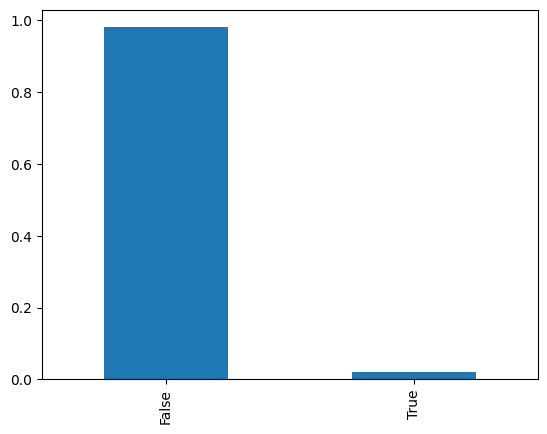

In [108]:
t = titanic_train[titanic_train['vip'].isna() == False]\
    ['cabin'].value_counts()\
    [
    titanic_train[titanic_train['vip'].isna() == False]\
        ['cabin'].value_counts() <= 1
].index

titanic_train.loc[titanic_train['cabin'].isin(t), :]['vip']\
    .value_counts(normalize=True).plot(kind='bar');

In [109]:
titanic_train.loc[titanic_train['cabin'].isin(t), :]['vip'].value_counts(normalize=True)

False    0.980575
True     0.019425
Name: vip, dtype: float64

Заполним оставшееся `False`.

In [110]:
for data in titanic:

    print(
        'Пропуски до: ', 
        data['vip'].isna().mean()
    )

    data['vip'] = \
        data['vip'].fillna(False)

    print(
        'Пропуски после: ', 
        data['vip'].isna().mean()
    )

Пропуски до:  0.01299896468422869
Пропуски после:  0.0
Пропуски до:  0.013327098433481413
Пропуски после:  0.0


### amenities

In [111]:
titanic_train.head(3)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,transported,passenger_id_group,passenger_id_number,deck,num,side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1.0,1,B,0.0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2.0,1,F,0.0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3.0,1,A,0.0,S


In [112]:
titanic_train.loc[(titanic_train[[
    'room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
        .isna() == True).any(axis=1)].head(3)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,name,transported,passenger_id_group,passenger_id_number,deck,num,side
7,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True,6.0,2,G,0.0,S
10,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True,8.0,2,B,1.0,P
16,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,Flats Eccle,False,14.0,1,F,3.0,P


Заполним нулями, где `'cryo_sleep' == True` нулями.

In [113]:
for data in titanic:

    print('Пропуски до: ', 
    data[[
        'room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
            .isna().mean().mean())

    data.loc[data['cryo_sleep'] == True, 
    ['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']] =\
        data.loc[data['cryo_sleep'] == True, 
    ['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
        .fillna(0)

    print('Пропуски после: ', 
    data[[
        'room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
            .isna().mean().mean())

Пропуски до:  0.021695617163234787
Пропуски после:  0.013137006787070055
Пропуски до:  0.021837736731353752
Пропуски после:  0.013794715922375498


In [114]:
titanic_train.loc[(titanic_train['cryo_sleep'] == False) & (
    titanic_train[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
        .sum(axis=1) == 0), 
['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']].isna().mean()

room_service     0.019305
food_court       0.019305
shopping_mall    0.017375
spa              0.007722
vrdeck           0.036680
dtype: float64

Процент пропусков, где `['cryo_sleep'] == False` и все услуги равны нулю.

In [115]:
titanic_train.loc[(titanic_train['cryo_sleep'] == False) & (
    titanic_train[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
        .sum(axis=1) == 0), 
['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']].isna().sum()

room_service     10
food_court       10
shopping_mall     9
spa               4
vrdeck           19
dtype: int64

In [116]:
titanic_train[[
    'room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
        .isna().sum()

room_service     113
food_court       112
shopping_mall    109
spa              116
vrdeck           121
dtype: int64

In [117]:
titanic_train[titanic_train['cryo_sleep'] == True][[
    'room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
        .isna().sum()

room_service     0
food_court       0
shopping_mall    0
spa              0
vrdeck           0
dtype: int64

Пропуски только там, где `['cryo_sleep'] == False`. Заполним оставшееся медианой.

In [118]:
for data in titanic:

    print('Пропуски до: ', 
    data[[
        'room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
            .isna().mean().mean())

    for label in ['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']:
        data.loc[:, label] = data.loc[:, label].fillna(data.loc[:, label].median())

    print('Пропуски после: ', 
    data[[
        'room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']]\
            .isna().mean().mean())

Пропуски до:  0.013137006787070055
Пропуски после:  0.0
Пропуски до:  0.013794715922375498
Пропуски после:  0.0


### name

In [119]:
titanic_train['name'].isna().mean()

0.023007017140227768

Для модели этот признак нам не нужен будет. Удалим.

In [120]:
for data in titanic:
    data.drop(labels='name', axis=1, inplace=True)

In [121]:
titanic_train.head(3)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,transported,passenger_id_group,passenger_id_number,deck,num,side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1.0,1,B,0.0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2.0,1,F,0.0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3.0,1,A,0.0,S


### final

In [122]:
titanic_train.isna().mean()

home_planet            0.010238
cryo_sleep             0.000000
cabin                  0.017715
destination            0.020936
age                    0.000000
vip                    0.000000
room_service           0.000000
food_court             0.000000
shopping_mall          0.000000
spa                    0.000000
vrdeck                 0.000000
transported            0.000000
passenger_id_group     0.000000
passenger_id_number    0.000000
deck                   0.017715
num                    0.017715
side                   0.017715
dtype: float64

In [123]:
titanic_train.head(3)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,transported,passenger_id_group,passenger_id_number,deck,num,side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1.0,1,B,0.0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2.0,1,F,0.0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3.0,1,A,0.0,S


Изучим еще раз `home_planet` и посмотрим как мы можем заполнить.

In [124]:
titanic_train[titanic_train['home_planet'].isna() == True]\
    ['passenger_id_group'].value_counts().value_counts()

1    87
2     1
Name: passenger_id_group, dtype: int64

In [125]:
titanic_test[titanic_test['home_planet'].isna() == True]\
    ['passenger_id_group'].value_counts().value_counts()

1    39
Name: passenger_id_group, dtype: int64

Пассажиры одиночки. Посмотрим с каких они планет.

In [126]:
t = titanic_train[titanic_train['home_planet'].isna() == False]\
    ['passenger_id_group'].value_counts()\
    [
    titanic_train[titanic_train['home_planet'].isna() == False]\
        ['passenger_id_group'].value_counts() <= 1
].index

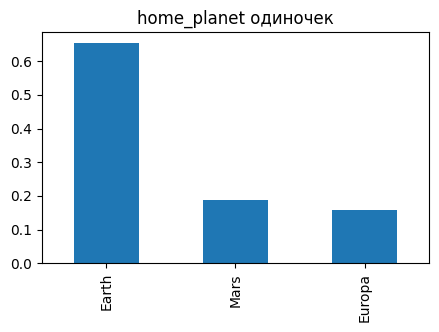

In [127]:
titanic_train.loc[titanic_train['passenger_id_group'].isin(t), :]\
    ['home_planet'].value_counts(normalize=True)\
        .plot(kind='bar', title='home_planet одиночек', figsize=(5,3));

In [128]:
titanic_train.loc[titanic_train['passenger_id_group'].isin(t), :]\
    .pivot_table(index='home_planet', 
    columns='destination', 
    values='passenger_id_group',
    aggfunc='count')

destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
home_planet,,,
Earth,427,521,2097
Europa,314,9,412
Mars,96,27,764


Заполним пропуски `Earth`, как максимально вероятным значением.

In [129]:
for data in titanic:

    data['home_planet'] = data['home_planet'].fillna('Earth')

In [130]:
titanic_train['home_planet'].isna().mean()

0.0

Рассмотрим `destination`.

In [131]:
titanic_train['destination'].isna().mean()

0.02093638559760727

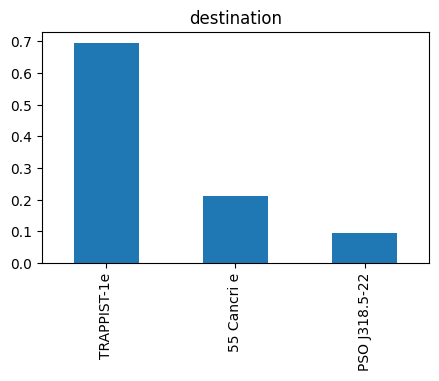

In [132]:
titanic_train\
    ['destination'].value_counts(normalize=True)\
        .plot(kind='bar', title='destination', figsize=(5,3));

* Мы пробовали заполнить по группам, но зашли в тупик: у группы разные планеты высадки.
* Заполним максимальным значением в группе.
* Остатки заполним также максимальным значением.

In [133]:
for data in titanic:

    print(
        'Пропуски до: ', 
        data['destination'].isna().mean()
    )

    t = data[data['destination'].isna() == False]\
        ['passenger_id_group'].value_counts()\
        [
        data[data['destination'].isna() == False]\
            ['passenger_id_group'].value_counts() > 1
    ].index

    data.loc[data['passenger_id_group'].isin(t), 'destination'] = \
        data.loc[data['passenger_id_group'].isin(t), :]\
            .groupby(by='passenger_id_group', group_keys=False)['destination']\
                .apply(lambda x: x.fillna(x.value_counts().index[0]))

    print(
        'Пропуски после: ', 
        data['destination'].isna().mean()
    )

Пропуски до:  0.02093638559760727
Пропуски после:  0.016680087426665133
Пропуски до:  0.021510404489127895
Пропуски после:  0.01589899462239888


Остатки заполним `TRAPPIST-1e`.

In [134]:
titanic_train['destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [135]:
for data in titanic:

    data['destination'] = data['destination'].fillna('TRAPPIST-1e')

In [136]:
for data in titanic:

    print(data['destination'].isna().mean())

0.0
0.0


Осталось `cabin`.

In [137]:
titanic_train.head(5)

,home_planet,cryo_sleep,cabin,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,transported,passenger_id_group,passenger_id_number,deck,num,side
0,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1.0,1,B,0.0,P
1,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2.0,1,F,0.0,S
2,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3.0,1,A,0.0,S
3,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3.0,2,A,0.0,S
4,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4.0,1,F,1.0,S


Заполним с помощью встроенного метода `‘ffill’` в `fillna()`.

In [138]:
for data in titanic:
    data.drop(labels='cabin', inplace=True, axis=1)
    data.fillna(method='ffill', inplace=True)

In [139]:
pd.DataFrame(data=titanic_train.isna().mean(), 
index=titanic_train.isna().mean().index).rename(columns={0: "titanic_train"})\
    .merge(
        right=pd.DataFrame(data=titanic_test.isna().mean(), 
index=titanic_test.isna().mean().index).rename(columns={0: "titanic_test"}),
left_index=True, right_index=True
    )

,titanic_train,titanic_test
home_planet,0.0,0.0
cryo_sleep,0.0,0.0
destination,0.0,0.0
age,0.0,0.0
vip,0.0,0.0
room_service,0.0,0.0
food_court,0.0,0.0
shopping_mall,0.0,0.0
spa,0.0,0.0
vrdeck,0.0,0.0


Пропуски заполнили

### Вывод

* Обнаружили пропуски в среднем 2% везде, кроме `PassengerId` и `Transported`.
* Перевели столбцы в `snake_case`.
* Дубликатов не обнаружено.
* Предобработку делали одинаково сразу на оба датасета.

**Данные изучали последовательно по столбцам.**

* `passenger_id`:
    * Дубликатов не обнаружено.
    * Разделили на два признака: номер самой группы и номер внутри группы.

* `home_planet`:
    * Обнаружено 2.3% пропусков train.
    * Частично заполнили пропуски по номерам групп пассажиров на основании, что группа улетает с одной планеты. Заполнили верно. Осталось еще 1.7% train.
    * С пропусками в `home_planet` остались лишь одиночки.
    * Оставили пока как есть, возможно в других признаках получится найти взаимосвязь для заполнения.

* `cryo_sleep`:
    * 2.4% пропусков.
    * `cryo_sleep` означает, что пассажир в анабиозе, значит не пользовался никакими услугами.
    * Мы увидели, что если в услугах везде нули, то это не означает, что пассажир был в криосне. По описанию услуги это лишь росскошь за отдельные деньги.
    * Необязательно пассажиры из одной группы находится в криосне или наоборот.
    * Заполнили `False`, если `titanic_train[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']].sum(axis=1) != 0`.
    * Оставалось 1.1% пропусков.
    * Чисто статистически при таком малом проценте заполнили при `data[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']].sum(axis=1) == 0` значением `True`, чтобы не давать нашей модели излишнее третье значение этого признака.
    * Все пропуски заполнены.

* `cabin`:
    * 2.2% пропусков.
    * Частично заполнили пропуски по номерам групп пассажиров на основании, что группа живет в одних номерах; использовали метод `‘ffill’` в `fillna()`.
    * 1.7% пропусков после такого заполнения.
    * Разделили и добавили новые столбцы `['deck', 'num', 'side']`: палуба, номер каюты, борт корабля.
    * Не получилось заполнить пропуски через группы пассажиров и связи с палубой.
    * Исследуя взаимосвязи как заполнить пропуски, заполнили частично пропуски:
        * `vip`, обнаружив палубы G и T без вип.
        * `home_planet`: на палубах `['B', 'A', 'C', 'T']` - Европа; на палубе `G` - земляне.
    * Заполнить пропуски полностью не удалось.

* `destination`:
    * 2% пропусков.
    * Заполнить по группам пассажиров не удалось. Люди из одной группы направляются на разные планеты. Оставили как есть.

* `age`:
    * 2% пропусков.
    * Заполнили пропуски медианой, где группа пассажиров состоит из 1 человека.
    * Стало 1.6%.
    * Остатки заполнили медианой по всей выборке.

* `vip`:
    * Обнаружили, что в одной каюте могут находиться и вип и не вип пассажиры.
    * Частично заполнили пропуски через каюты с помощью `max()` по каюте.
    * Остатки заполнили `False` как `max()` по всей выборке, поскольку процент `False` равен 98.

* `amenities` - услуги:
    * 2.1% пропусков.
    * Заполнили пропуски нулями, где `'cryo_sleep' == True`.
    * Остатки 1.3% только там, где `['cryo_sleep'] == False`. Заполнили оставшееся медианой.

* `name`:
    * Удалили этот признак.

**Еще раз прошлись по остаточным пропускам.**

* После очевидных взаимосвязей, остатки заполняли общими правилами:

    * 1% пропусков `home_planet` заполнили `Earth`, как максимально вероятным значением.
    * 2% пропусков `destination` заполнили максимальным значением в группе. Остатки заполнили `TRAPPIST-1e`.
    * В `cabin` 1.6% пропусков заполнили с помощью встроенного метода `‘ffill’` в `fillna()`.

**Итого заполнили все пропуски.**

## План работы

* Подготовить данные для модели.
* Обучить модель `CatBoost` без подбора гиперпараметров и посмотреть на `feature_importance`.
* Сделать отбор признаков
* Подобрать лучшие гиперпараметры с помощью Optuna.
* Подобрать treshhold.
* Выбрать лучшую модель, обучить, сделать предсказание, загрузить на Kaggle и получить результат.

## Подготовка выборки

Добавим еще 1 признак — сумму расходов.

In [140]:
for data in titanic:

    data['amenities_sum'] = \
        data[
            ['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']
            ].sum(axis=1)

In [141]:
titanic_test.head(3)

,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,passenger_id_group,passenger_id_number,deck,num,side,amenities_sum
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,13.0,1,G,3.0,S,0.0
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,18.0,1,F,4.0,S,2832.0
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,19.0,1,C,0.0,S,0.0


Взглянем на баланс классов.

In [142]:
titanic_train['transported'].value_counts(normalize=True)

True     0.503624
False    0.496376
Name: transported, dtype: float64

Классы сбалансированы. Взглянем на типы данных.

In [143]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   home_planet          8693 non-null   object 
 1   cryo_sleep           8693 non-null   bool   
 2   destination          8693 non-null   object 
 3   age                  8693 non-null   float64
 4   vip                  8693 non-null   bool   
 5   room_service         8693 non-null   float64
 6   food_court           8693 non-null   float64
 7   shopping_mall        8693 non-null   float64
 8   spa                  8693 non-null   float64
 9   vrdeck               8693 non-null   float64
 10  transported          8693 non-null   bool   
 11  passenger_id_group   8693 non-null   float64
 12  passenger_id_number  8693 non-null   int32  
 13  deck                 8693 non-null   object 
 14  num                  8693 non-null   float64
 15  side                 8693 non-null   o

`cryo_sleep`, `transported` и `vip` изменим на 1 и 0.

In [144]:
for data in titanic:
    data['cryo_sleep'] = data['cryo_sleep'] * 1
    data['vip'] = data['vip'] * 1

titanic_train['transported'] = titanic_train['transported'] * 1

In [145]:
titanic_train.head(5)

,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,transported,passenger_id_group,passenger_id_number,deck,num,side,amenities_sum
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,1,B,0.0,P,0.0
1,Earth,0,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,1,2.0,1,F,0.0,S,736.0
2,Europa,0,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,3.0,1,A,0.0,S,10383.0
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,3.0,2,A,0.0,S,5176.0
4,Earth,0,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,1,4.0,1,F,1.0,S,1091.0


Применим `OrdinalEncoder`.

In [146]:
oe_f = ['home_planet', 'destination', 'deck', 'side']

enc = OrdinalEncoder().fit(titanic_train[oe_f])
titanic_train[oe_f] = enc.transform(titanic_train[oe_f])
titanic_test[oe_f] = enc.transform(titanic_test[oe_f])

In [147]:
titanic_train.head(3)

,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,transported,passenger_id_group,passenger_id_number,deck,num,side,amenities_sum
0,1.0,0,2.0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,1,1.0,0.0,0.0,0.0
1,0.0,0,2.0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,2.0,1,5.0,0.0,1.0,736.0
2,1.0,0,2.0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,3.0,1,0.0,0.0,1.0,10383.0


In [148]:
titanic_test.head(3)

,home_planet,cryo_sleep,destination,age,vip,room_service,food_court,shopping_mall,spa,vrdeck,passenger_id_group,passenger_id_number,deck,num,side,amenities_sum
0,0.0,1,2.0,27.0,0,0.0,0.0,0.0,0.0,0.0,13.0,1,6.0,3.0,1.0,0.0
1,0.0,0,2.0,19.0,0,0.0,9.0,0.0,2823.0,0.0,18.0,1,5.0,4.0,1.0,2832.0
2,1.0,1,0.0,31.0,0,0.0,0.0,0.0,0.0,0.0,19.0,1,2.0,0.0,1.0,0.0


Масштабирование для `CatBoost` не нужно. Сделаем константные предсказания.

In [149]:
data=titanic_train.drop(labels='transported', axis=1)
target=titanic_train['transported']

In [150]:
y_const = pd.Series([1] * len(target), index=target.index)

roc_auc_const = roc_auc_score(target, y_const)
acc_const = accuracy_score(target, y_const).round(3)
f1_const = round(f1_score(target, y_const), 3)

print('Константное предсказание ROC_AUC: ', roc_auc_const)
print('Константное предсказание Accuracy: ', acc_const)
print('Константное предсказание F1_score: ', f1_const)

Константное предсказание ROC_AUC:  0.5
Константное предсказание Accuracy:  0.504
Константное предсказание F1_score:  0.67


### Выводы

* Добавили новый признак — сумму расходов `amenities_sum`.
* Классы сбалансированы:
    * True — 0.503624
    * False — 0.496376

* `cryo_sleep`, `transported` и `vip` изменили на 1 и 0.
* Применили `OrdinalEncoder` к признакам `['home_planet', 'destination', 'deck', 'side']`.
* Масштабирование для `CatBoost` не нужно.
* Константные метрики:
    * ROC_AUC:  0.5
    * Accuracy:  0.506
    * F1_score:  0.672

## feature_importance

In [151]:
# Базовая модель CatBoost

def cat_model_base(data, target):

    params = {'eval_metric': 'Logloss',
            'loss_function': 'Logloss',
            'random_seed': 290822,
            'iterations': 5000,
            'early_stopping_rounds': 200,
            'verbose':False}

    cat_train = Pool(data=data, label=target)

    cat = CatBoostClassifier(**params)
    cat.fit(cat_train)

    print('train предсказание ROC_AUC: ', 
    roc_auc_score(target, cat.predict(cat_train)).round(5),
    'const: ', roc_auc_const)

    print('train предсказание Accuracy: ', 
    accuracy_score(target, cat.predict(cat_train)).round(5),
    'const: ', acc_const)

    print('train предсказание F1_score: ', 
    f1_score(target, cat.predict(cat_train)).round(5),
    'const: ', f1_const)

    return cat

Обучим базово модель и изучим признаки.

In [152]:
%%time

cat = cat_model_base(data, target)

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


train предсказание ROC_AUC:  0.88917 const:  0.5
train предсказание Accuracy:  0.88922 const:  0.504
train предсказание F1_score:  0.89063 const:  0.67
CPU times: total: 1min 51s
Wall time: 13 s


In [153]:
submission['Transported'] = cat.predict(titanic_test)
submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('submission-base.csv', index=False)

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Score: 0.79845.

In [154]:
cat_train = Pool(data=data, label=target)

cat.get_feature_importance(data=cat_train,
                       prettified=True)

,Feature Id,Importances
0,amenities_sum,11.581804
1,deck,10.760412
2,home_planet,9.082183
3,num,8.989505
4,spa,8.935033
5,vrdeck,8.249500
6,food_court,7.432508
7,age,6.501115
8,cryo_sleep,6.077589
9,room_service,5.333630


Все признаки равнозначны примерно, кроме последних трех. Удалим последние три признака и посмотрим как изменится качество.

In [155]:
data.columns

Index(['home_planet', 'cryo_sleep', 'destination', 'age', 'vip',
       'room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck',
       'passenger_id_group', 'passenger_id_number', 'deck', 'num', 'side',
       'amenities_sum'],
      dtype='object')

In [156]:
data_cut = data.drop(
    labels=['vip', 'passenger_id_number', 'destination'], axis=1)

data_cut.shape

(8693, 13)

In [157]:
%%time

cat_model_base(data_cut, target)

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


train предсказание ROC_AUC:  0.88241 const:  0.5
train предсказание Accuracy:  0.88255 const:  0.504
train предсказание F1_score:  0.8855 const:  0.67
CPU times: total: 1min 50s
Wall time: 12.8 s


Качество ухудшилось. Сделаем еще 2 эксперимента: без последних двух и без последнего признака.

In [158]:
%%time

for labels in [
    ['vip', 'passenger_id_number'],
    ['vip']
        ]:
    
    data_cut = data.drop(
        labels=labels, axis=1)

    print('Количество признаков:', data_cut.shape[1], '\n',
        'Удалили признаки:', labels, '\n')
    cat_model_base(data_cut, target)

Количество признаков: 14 
 Удалили признаки: ['vip', 'passenger_id_number'] 



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


train предсказание ROC_AUC:  0.88641 const:  0.5
train предсказание Accuracy:  0.88646 const:  0.504
train предсказание F1_score:  0.88796 const:  0.67
Количество признаков: 15 
 Удалили признаки: ['vip'] 



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


train предсказание ROC_AUC:  0.88756 const:  0.5
train предсказание Accuracy:  0.88761 const:  0.504
train предсказание F1_score:  0.88917 const:  0.67
CPU times: total: 4min 6s
Wall time: 27.9 s


Прежние метрики:

```
train предсказание ROC_AUC:  0.88917 const:  0.5
train предсказание Accuracy:  0.88922 const:  0.504
train предсказание F1_score:  0.89063 const:  0.67
```

Смысла удалять `vip` нет, как и другие признаки.

### Вывод

* Обучили базово `CatBoost`.
* Получили метрики:
    * train предсказание ROC_AUC:  0.88917 const:  0.5
    * train предсказание Accuracy:  0.88922 const:  0.504
    * train предсказание F1_score:  0.89063 const:  0.67
* Изучили с помощью метода `.get_feature_importance` важность признаков.
* Методом перебора наименее важных признаков `['vip', 'passenger_id_number', 'destination']` определили, что видимой причины удалять какой-либо признак нет.

* Получили базово Score: 0.79845 на Kaggle.

## Подбор гиперпараметров

Для подбора используем библиотеку Optuna.

In [159]:
def objective(trial,
data=data,
target=target):
    
    global n_iter_row

    params = {
        'loss_function': 'Logloss',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10.0),
        'max_bin': trial.suggest_int('max_bin', 128, 254),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),
        'rsm': trial.suggest_float('rsm', 0.3, 1.0),
        'iterations':  25000,
        'max_depth': trial.suggest_int("max_depth", 1, 16),
        'random_state': trial.suggest_categorical('random_state', [13]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }

    cat_train = Pool(data=data, label=target)

    print('Start CV ...')

    cv_data = cv(
            params = params,
            pool = cat_train,
            shuffle=True,
            stratified=True,
            verbose=False,
            nfold = 5,
            early_stopping_rounds=200
            )

    n_iter = np.argmin(cv_data['test-Logloss-mean'])

    n_iter_row.append(n_iter)

    if params["iterations"] == 25000:
        params["iterations"] = n_iter

    cat = CatBoostClassifier(**params, verbose=False)
    cat.fit(cat_train)

    state = np.random.RandomState(13)
    values = []

    # Bootstrap
    for i in range(100):
        target_subsample = target\
            .sample(frac=0.25, replace=True, random_state=state)
        predicts_subsample = data\
            .iloc[target_subsample.index]
        cat_train = Pool(data=predicts_subsample, label=target_subsample)
        
        values.append(roc_auc_score(target_subsample, cat.predict(cat_train)))

    score = np.median(values)
    
    return score

Запустим поиск.

In [161]:
%%time

n_iter_row = []

study = optuna.create_study(direction='maximize')
study.optimize(objective, 
                n_trials=40)

[I 2022-10-10 19:27:18,846] A new study created in memory with name: no-name-1780c899-09a0-4ca3-aa98-111deea503a6
C:\Users\Счастливый\AppData\Local\Temp\ipykernel_9084\2746722273.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10.0),


Start CV ...
Training on fold [0/5]

bestTest = 0.4065670947
bestIteration = 370

Training on fold [1/5]

bestTest = 0.4341545799
bestIteration = 285

Training on fold [2/5]

bestTest = 0.424414704
bestIteration = 329

Training on fold [3/5]

bestTest = 0.4167082876
bestIteration = 337

Training on fold [4/5]

bestTest = 0.3817550584
bestIteration = 383



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3802880207
bestIteration = 4238

Training on fold [1/5]

bestTest = 0.4026238587
bestIteration = 3647

Training on fold [2/5]

bestTest = 0.3946645311
bestIteration = 3064

Training on fold [3/5]

bestTest = 0.3893935945
bestIteration = 5293

Training on fold [4/5]

bestTest = 0.3444979143
bestIteration = 5985



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4122988407
bestIteration = 231

Training on fold [1/5]

bestTest = 0.4374265909
bestIteration = 224

Training on fold [2/5]

bestTest = 0.4232540206
bestIteration = 234

Training on fold [3/5]

bestTest = 0.4189321899
bestIteration = 226

Training on fold [4/5]

bestTest = 0.3822639517
bestIteration = 300



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3809197729
bestIteration = 4785

Training on fold [1/5]

bestTest = 0.4064273205
bestIteration = 3374

Training on fold [2/5]

bestTest = 0.3975548605
bestIteration = 3313

Training on fold [3/5]

bestTest = 0.3923332284
bestIteration = 5658

Training on fold [4/5]

bestTest = 0.3484161134
bestIteration = 7442



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3918908572
bestIteration = 476

Training on fold [1/5]

bestTest = 0.4155644464
bestIteration = 410

Training on fold [2/5]

bestTest = 0.4074653081
bestIteration = 358

Training on fold [3/5]

bestTest = 0.402427395
bestIteration = 403

Training on fold [4/5]

bestTest = 0.3630667504
bestIteration = 621



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.381680621
bestIteration = 2874

Training on fold [1/5]

bestTest = 0.4051108396
bestIteration = 2316

Training on fold [2/5]

bestTest = 0.3957826926
bestIteration = 2140

Training on fold [3/5]

bestTest = 0.3889270697
bestIteration = 4461

Training on fold [4/5]

bestTest = 0.3448384818
bestIteration = 5156



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.417491386
bestIteration = 103

Training on fold [1/5]

bestTest = 0.443354565
bestIteration = 97

Training on fold [2/5]

bestTest = 0.4387993727
bestIteration = 91

Training on fold [3/5]

bestTest = 0.4212617164
bestIteration = 115

Training on fold [4/5]

bestTest = 0.3936519024
bestIteration = 145



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3810240393
bestIteration = 2580

Training on fold [1/5]

bestTest = 0.4065146529
bestIteration = 2497

Training on fold [2/5]

bestTest = 0.3921725672
bestIteration = 2536

Training on fold [3/5]

bestTest = 0.3905152407
bestIteration = 3245

Training on fold [4/5]

bestTest = 0.3507382148
bestIteration = 3630



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3805875165
bestIteration = 4279

Training on fold [1/5]

bestTest = 0.4049772163
bestIteration = 2789

Training on fold [2/5]

bestTest = 0.3972354747
bestIteration = 2966

Training on fold [3/5]

bestTest = 0.3903124051
bestIteration = 5382

Training on fold [4/5]

bestTest = 0.345915197
bestIteration = 5870



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3938054001
bestIteration = 679

Training on fold [1/5]

bestTest = 0.4195503887
bestIteration = 620

Training on fold [2/5]

bestTest = 0.4061249162
bestIteration = 615

Training on fold [3/5]

bestTest = 0.4028332722
bestIteration = 652

Training on fold [4/5]

bestTest = 0.3663459567
bestIteration = 964



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.440373481
bestIteration = 24999

Training on fold [1/5]

bestTest = 0.4549519246
bestIteration = 24999

Training on fold [2/5]

bestTest = 0.4561856241
bestIteration = 24999

Training on fold [3/5]

bestTest = 0.4525762441
bestIteration = 24997

Training on fold [4/5]

bestTest = 0.427352384
bestIteration = 24999



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4202291008
bestIteration = 122

Training on fold [1/5]

bestTest = 0.4429919945
bestIteration = 101

Training on fold [2/5]

bestTest = 0.4413624708
bestIteration = 138

Training on fold [3/5]

bestTest = 0.4329649915
bestIteration = 127

Training on fold [4/5]

bestTest = 0.3967277696
bestIteration = 134



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.405188973
bestIteration = 588

Training on fold [1/5]

bestTest = 0.4247566278
bestIteration = 572

Training on fold [2/5]

bestTest = 0.4172207282
bestIteration = 634

Training on fold [3/5]

bestTest = 0.4094392252
bestIteration = 713

Training on fold [4/5]

bestTest = 0.3740045205
bestIteration = 839



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3925330871
bestIteration = 586

Training on fold [1/5]

bestTest = 0.4227442954
bestIteration = 459

Training on fold [2/5]

bestTest = 0.4111889492
bestIteration = 562

Training on fold [3/5]

bestTest = 0.405767031
bestIteration = 500

Training on fold [4/5]

bestTest = 0.3731436367
bestIteration = 718



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3951660437
bestIteration = 549

Training on fold [1/5]

bestTest = 0.4227071461
bestIteration = 374

Training on fold [2/5]

bestTest = 0.4112608138
bestIteration = 487

Training on fold [3/5]

bestTest = 0.4044917608
bestIteration = 509

Training on fold [4/5]

bestTest = 0.3701368231
bestIteration = 649



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3960310311
bestIteration = 466

Training on fold [1/5]

bestTest = 0.4243257006
bestIteration = 417

Training on fold [2/5]

bestTest = 0.4145185393
bestIteration = 526

Training on fold [3/5]

bestTest = 0.4066973068
bestIteration = 521

Training on fold [4/5]

bestTest = 0.3746134258
bestIteration = 540



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3850493371
bestIteration = 3172

Training on fold [1/5]

bestTest = 0.4122922656
bestIteration = 2477

Training on fold [2/5]

bestTest = 0.3973251053
bestIteration = 3152

Training on fold [3/5]

bestTest = 0.392545035
bestIteration = 3110

Training on fold [4/5]

bestTest = 0.3530915556
bestIteration = 4401



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4072817313
bestIteration = 225

Training on fold [1/5]

bestTest = 0.4371588497
bestIteration = 214

Training on fold [2/5]

bestTest = 0.427627896
bestIteration = 220

Training on fold [3/5]

bestTest = 0.415721974
bestIteration = 245

Training on fold [4/5]

bestTest = 0.38928972
bestIteration = 259



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3835791798
bestIteration = 1826

Training on fold [1/5]

bestTest = 0.4092362995
bestIteration = 1524

Training on fold [2/5]

bestTest = 0.3975056598
bestIteration = 1516

Training on fold [3/5]

bestTest = 0.3919189926
bestIteration = 1846

Training on fold [4/5]

bestTest = 0.3519445099
bestIteration = 1896



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4112700605
bestIteration = 150

Training on fold [1/5]

bestTest = 0.4356836307
bestIteration = 163

Training on fold [2/5]

bestTest = 0.4283248741
bestIteration = 145

Training on fold [3/5]

bestTest = 0.4192628301
bestIteration = 142

Training on fold [4/5]

bestTest = 0.385686227
bestIteration = 182



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4020556544
bestIteration = 595

Training on fold [1/5]

bestTest = 0.4271759659
bestIteration = 489

Training on fold [2/5]

bestTest = 0.4205112158
bestIteration = 554

Training on fold [3/5]

bestTest = 0.4096281304
bestIteration = 564

Training on fold [4/5]

bestTest = 0.3737789934
bestIteration = 820



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3940143275
bestIteration = 990

Training on fold [1/5]

bestTest = 0.4208018684
bestIteration = 832

Training on fold [2/5]

bestTest = 0.4083299635
bestIteration = 1018

Training on fold [3/5]

bestTest = 0.4023236227
bestIteration = 959

Training on fold [4/5]

bestTest = 0.3708250408
bestIteration = 1322



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4010335054
bestIteration = 284

Training on fold [1/5]

bestTest = 0.4271437196
bestIteration = 254

Training on fold [2/5]

bestTest = 0.4167589292
bestIteration = 285

Training on fold [3/5]

bestTest = 0.4088333625
bestIteration = 277

Training on fold [4/5]

bestTest = 0.3768474541
bestIteration = 349



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3987559022
bestIteration = 455

Training on fold [1/5]

bestTest = 0.4279565261
bestIteration = 315

Training on fold [2/5]

bestTest = 0.4157476107
bestIteration = 375

Training on fold [3/5]

bestTest = 0.4104417002
bestIteration = 403

Training on fold [4/5]

bestTest = 0.3761453389
bestIteration = 566



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3959745704
bestIteration = 291

Training on fold [1/5]

bestTest = 0.4234926897
bestIteration = 313

Training on fold [2/5]

bestTest = 0.414330868
bestIteration = 359

Training on fold [3/5]

bestTest = 0.4020549975
bestIteration = 353

Training on fold [4/5]

bestTest = 0.3677954529
bestIteration = 438



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4123971503
bestIteration = 141

Training on fold [1/5]

bestTest = 0.4448041171
bestIteration = 120

Training on fold [2/5]

bestTest = 0.4329567647
bestIteration = 143

Training on fold [3/5]

bestTest = 0.420870603
bestIteration = 150

Training on fold [4/5]

bestTest = 0.3934242239
bestIteration = 186



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3941938397
bestIteration = 616

Training on fold [1/5]

bestTest = 0.4219190215
bestIteration = 428

Training on fold [2/5]

bestTest = 0.4105710726
bestIteration = 574

Training on fold [3/5]

bestTest = 0.4034922171
bestIteration = 576

Training on fold [4/5]

bestTest = 0.3707388777
bestIteration = 756



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3987763609
bestIteration = 304

Training on fold [1/5]

bestTest = 0.4296145904
bestIteration = 271

Training on fold [2/5]

bestTest = 0.4189905959
bestIteration = 296

Training on fold [3/5]

bestTest = 0.4132062281
bestIteration = 270

Training on fold [4/5]

bestTest = 0.3753217294
bestIteration = 400



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3882430859
bestIteration = 2667

Training on fold [1/5]

bestTest = 0.4153251408
bestIteration = 2296

Training on fold [2/5]

bestTest = 0.4004201913
bestIteration = 2766

Training on fold [3/5]

bestTest = 0.3987975575
bestIteration = 2759

Training on fold [4/5]

bestTest = 0.363022376
bestIteration = 3530



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3842027595
bestIteration = 1694

Training on fold [1/5]

bestTest = 0.4115392646
bestIteration = 1173

Training on fold [2/5]

bestTest = 0.3968112373
bestIteration = 1444

Training on fold [3/5]

bestTest = 0.3929252205
bestIteration = 2099

Training on fold [4/5]

bestTest = 0.3496762273
bestIteration = 2308



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4015826923
bestIteration = 517

Training on fold [1/5]

bestTest = 0.428951573
bestIteration = 420

Training on fold [2/5]

bestTest = 0.4208558665
bestIteration = 478

Training on fold [3/5]

bestTest = 0.4128884071
bestIteration = 505

Training on fold [4/5]

bestTest = 0.3797923632
bestIteration = 654



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4011311542
bestIteration = 474

Training on fold [1/5]

bestTest = 0.4295649514
bestIteration = 427

Training on fold [2/5]

bestTest = 0.4215056598
bestIteration = 399

Training on fold [3/5]

bestTest = 0.4131443137
bestIteration = 397

Training on fold [4/5]

bestTest = 0.3805081155
bestIteration = 537



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3968648566
bestIteration = 800

Training on fold [1/5]

bestTest = 0.4245417639
bestIteration = 675

Training on fold [2/5]

bestTest = 0.4131030064
bestIteration = 746

Training on fold [3/5]

bestTest = 0.4070434923
bestIteration = 839

Training on fold [4/5]

bestTest = 0.3762583876
bestIteration = 1104



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3961692424
bestIteration = 496

Training on fold [1/5]

bestTest = 0.4254725711
bestIteration = 411

Training on fold [2/5]

bestTest = 0.4142998693
bestIteration = 556

Training on fold [3/5]

bestTest = 0.4071009095
bestIteration = 474

Training on fold [4/5]

bestTest = 0.3731540142
bestIteration = 635



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4105964862
bestIteration = 236

Training on fold [1/5]

bestTest = 0.4388344316
bestIteration = 205

Training on fold [2/5]

bestTest = 0.43411619
bestIteration = 203

Training on fold [3/5]

bestTest = 0.4229706842
bestIteration = 242

Training on fold [4/5]

bestTest = 0.3912910526
bestIteration = 261



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4123599472
bestIteration = 179

Training on fold [1/5]

bestTest = 0.4386876659
bestIteration = 179

Training on fold [2/5]

bestTest = 0.4356994519
bestIteration = 192

Training on fold [3/5]

bestTest = 0.4226464713
bestIteration = 177

Training on fold [4/5]

bestTest = 0.3910909788
bestIteration = 252



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4018454857
bestIteration = 9105

Training on fold [1/5]

bestTest = 0.4138046328
bestIteration = 9313

Training on fold [2/5]

bestTest = 0.4105231971
bestIteration = 11460

Training on fold [3/5]

bestTest = 0.4002650702
bestIteration = 19169

Training on fold [4/5]

bestTest = 0.3588452561
bestIteration = 19915



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4111830992
bestIteration = 208

Training on fold [1/5]

bestTest = 0.43684156
bestIteration = 192

Training on fold [2/5]

bestTest = 0.4370872469
bestIteration = 191

Training on fold [3/5]

bestTest = 0.4270386494
bestIteration = 188

Training on fold [4/5]

bestTest = 0.3908042733
bestIteration = 241



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.4048058219
bestIteration = 322

Training on fold [1/5]

bestTest = 0.4266734697
bestIteration = 323

Training on fold [2/5]

bestTest = 0.420453286
bestIteration = 325

Training on fold [3/5]

bestTest = 0.411109364
bestIteration = 332

Training on fold [4/5]

bestTest = 0.3785056994
bestIteration = 454



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

Start CV ...
Training on fold [0/5]

bestTest = 0.3993957265
bestIteration = 529

Training on fold [1/5]

bestTest = 0.4248281351
bestIteration = 447

Training on fold [2/5]

bestTest = 0.4147172451
bestIteration = 512

Training on fold [3/5]

bestTest = 0.4076319398
bestIteration = 531

Training on fold [4/5]

bestTest = 0.3697456008
bestIteration = 852



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed 

CPU times: total: 2d 7h 23min 25s
Wall time: 9h 15min 3s


Результат после долгих ожиданий.

In [162]:
print('Optimization is finished... \n')
print('Number of finished trials:', len(study.trials))
print('Best trial № {0} \nBest params: \n {1}'
.format(study.best_trial.number, study.best_trial.params)) 
print('Best value:', study.best_value)
print('n_iter:', n_iter_row[study.best_trial.number])

Optimization is finished... 

Number of finished trials: 40
Best trial № 37 
Best params: 
 {'l2_leaf_reg': 0.0016058801002002293, 'max_bin': 136, 'bagging_temperature': 0.8831675794948042, 'learning_rate': 0.005740980536394578, 'rsm': 0.7405963017824208, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 189}
Best value: 0.9419196861736415
n_iter: 208


Взглянем на важность гиперпараметров.

In [163]:
optuna.visualization.plot_param_importances(study)

Основную роль играет глубина дерева. В нашем случае она равна 16 в best trial. Сам CatBoost позволяет максимум 16.

In [164]:
optuna.visualization.plot_optimization_history(study)

In [165]:
%%time

cat_train = Pool(data=data, 
    label=target)

cat = CatBoostClassifier(**study.best_trial.params, 
                        verbose=False,
                        iterations=n_iter_row[study.best_trial.number])
cat.fit(cat_train)

print('CatBoost with Optuna', '\n')

print('train  ROC_AUC: ', 
roc_auc_score(target, cat.predict(cat_train)).round(5),
'| Const: ', roc_auc_const)

print('train  Accuracy: ', 
accuracy_score(target, cat.predict(cat_train)).round(5),
'| Const: ', acc_const)

print('train  F1_score: ', 
f1_score(target, cat.predict(cat_train)).round(5),
'| Const: ', f1_const, '\n')

print('Best params: \n', study.best_trial.params, '\n')
print('Best iter: \n', 
n_iter_row[study.best_trial.number], '\n')

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



CatBoost with Optuna 

train  ROC_AUC:  0.94247 | Const:  0.5
train  Accuracy:  0.94271 | Const:  0.504
train  F1_score:  0.94492 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.0016058801002002293, 'max_bin': 136, 'bagging_temperature': 0.8831675794948042, 'learning_rate': 0.005740980536394578, 'rsm': 0.7405963017824208, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 189} 

Best iter: 
 208 

CPU times: total: 14min 54s
Wall time: 2min 17s


Метрики по CatBoost с Optuna, где используется кроссвалидация.
~~~
CatBoost with Optuna 

train  ROC_AUC:  0.94247 | Const:  0.5
train  Accuracy:  0.94271 | Const:  0.504
train  F1_score:  0.94492 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.0016058801002002293, 'max_bin': 136, 'bagging_temperature': 0.8831675794948042, 'learning_rate': 0.005740980536394578, 'rsm': 0.7405963017824208, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 189} 

Best iter: 
 208 
 ~~~

**Вывод:**

Использовали:

* Optuna c максимизацией score;
* cv от CatBoost;
* Score по медиане Bootstrap на 100 раз с долей roc_aug предсказаний 0.25 от выборки;
* Количество trial – 40.

Результаты:

* В гиперпараметрах основную роль на метрику играет max_depth: доля 0.64.
* train выборка:

~~~
CatBoost with Optuna 

train  ROC_AUC:  0.94247 | Const:  0.5
train  Accuracy:  0.94271 | Const:  0.504
train  F1_score:  0.94492 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.0016058801002002293, 'max_bin': 136, 'bagging_temperature': 0.8831675794948042, 'learning_rate': 0.005740980536394578, 'rsm': 0.7405963017824208, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 189} 

Best iter: 
 208 
 ~~~

## Submission

Проверим score на Kaggle.

In [166]:
submission['Transported'] = cat.predict(titanic_test)
submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('submission-optuna.csv', index=False)

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Score: 0.78910.

Метрика низкая, ожидалась выше. Применим ROC_AUG кривую и установим лучший threshhold.

In [167]:
(fpr, tpr, thresholds) = get_roc_curve(cat, cat_train)
sum = tpr + (1-fpr)
cat.set_probability_threshold(thresholds[np.argmax(sum)])

In [168]:
print('CatBoost with Optuna & thrs', '\n')

print('train  ROC_AUC: ', 
roc_auc_score(target, cat.predict(cat_train)).round(5),
'| Const: ', roc_auc_const)

print('train  Accuracy: ', 
accuracy_score(target, cat.predict(cat_train)).round(5),
'| Const: ', acc_const)

print('train  F1_score: ', 
f1_score(target, cat.predict(cat_train)).round(5),
'| Const: ', f1_const, '\n')

print('Best params: \n', study.best_trial.params, '\n')
print('Best iter: \n', 
n_iter_row[study.best_trial.number], '\n')

CatBoost with Optuna & thrs 

train  ROC_AUC:  0.94633 | Const:  0.5
train  Accuracy:  0.94639 | Const:  0.504
train  F1_score:  0.94725 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.0016058801002002293, 'max_bin': 136, 'bagging_temperature': 0.8831675794948042, 'learning_rate': 0.005740980536394578, 'rsm': 0.7405963017824208, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 189} 

Best iter: 
 208 



In [169]:
submission['Transported'] = cat.predict(titanic_test)
submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('submission-optuna-thrs.csv', index=False)

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Score: 0.78653. Еще чуть ниже.

Сделаем возможный вывод:

* Использовали в функции оптимизации Optuna кроссвалидацию cv самого CatBoost, что должно помогать от переобучения.
* Использовали бутстреп 100 раз на результирующий score в функции оптимизации с долей 0.25 от всей выборки на предсказание метрики ROC_AUG. При этом брали медиану от всех полученных значений.
* По идее мы защитили себя от переобучения и оптимизировали score от случайностей.
* Отсюда можно предположить:
    * test выборка по данным отлична от train
    * Можно для улучшения результата использовать бутстреп не с медианой по результату, а например с 2% квантилем. А также уменьшить долю для предсказаний в бустреп.

Итог:

 * Результат без threshold: 0.78910;
 * Результат с threshold: 0.78653.

## Поиск улучшения результата.

In [170]:
def objective(trial,
data=data,
target=target):
    
    global n_iter_row

    params = {
        'loss_function': 'Logloss',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10.0),
        'max_bin': trial.suggest_int('max_bin', 128, 254),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),
        'rsm': trial.suggest_float('rsm', 0.3, 1.0),
        'iterations':  25000,
        'max_depth': trial.suggest_int("max_depth", 1, 16),
        'random_state': trial.suggest_categorical('random_state', [13]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }

    cat_train = Pool(data=data, label=target)

    print('Start CV ...')

    cv_data = cv(
            params = params,
            pool = cat_train,
            shuffle=True,
            stratified=True,
            verbose=False,
            nfold = 5,
            early_stopping_rounds=200
            )

    n_iter = np.argmin(cv_data['test-Logloss-mean'])

    n_iter_row.append(n_iter)

    if params["iterations"] == 25000:
        params["iterations"] = n_iter

    cat = CatBoostClassifier(**params, verbose=False)
    cat.fit(cat_train)

    state = np.random.RandomState(13)
    values = []

    # Bootstrap
    for i in range(100):
        target_subsample = target\
            .sample(frac=0.1, replace=True, random_state=state)
        predicts_subsample = data\
            .loc[target_subsample.index, :]
        cat_train = Pool(data=predicts_subsample, label=target_subsample)
        
        values.append(roc_auc_score(target_subsample, cat.predict(cat_train)))

    score = pd.Series(values).quantile(0.02)
    
    return score

In [171]:
%%time

n_iter_row = []

study = optuna.create_study(direction='maximize')
study.optimize(objective, 
                n_trials=40)

[I 2022-10-11 06:00:20,556] A new study created in memory with name: no-name-42daa7eb-b8f3-4fd5-832b-2c0620a47ed6
C:\Users\Счастливый\AppData\Local\Temp\ipykernel_9084\198624288.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.



Start CV ...
Training on fold [0/5]

bestTest = 0.3874973723
bestIteration = 21581

Training on fold [1/5]

bestTest = 0.4068074747
bestIteration = 18217

Training on fold [2/5]

bestTest = 0.4006979983
bestIteration = 16561

Training on fold [3/5]

bestTest = 0.3956656958
bestIteration = 24599

Training on fold [4/5]

bestTest = 0.3556018512
bestIteration = 24895



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.405904203
bestIteration = 1090

Training on fold [1/5]

bestTest = 0.4301309365
bestIteration = 900

Training on fold [2/5]

bestTest = 0.4223697545
bestIteration = 1041

Training on fold [3/5]

bestTest = 0.4118711699
bestIteration = 1042

Training on fold [4/5]

bestTest = 0.3758836771
bestIteration = 1301



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3889516155
bestIteration = 1068

Training on fold [1/5]

bestTest = 0.413391409
bestIteration = 1054

Training on fold [2/5]

bestTest = 0.3985985009
bestIteration = 1257

Training on fold [3/5]

bestTest = 0.39637993
bestIteration = 1460

Training on fold [4/5]

bestTest = 0.3540596862
bestIteration = 2019



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4027647343
bestIteration = 243

Training on fold [1/5]

bestTest = 0.4274011778
bestIteration = 214

Training on fold [2/5]

bestTest = 0.41555343
bestIteration = 242

Training on fold [3/5]

bestTest = 0.4100318454
bestIteration = 232

Training on fold [4/5]

bestTest = 0.3751942111
bestIteration = 375



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4049612557
bestIteration = 24995

Training on fold [1/5]

bestTest = 0.4179718137
bestIteration = 24997

Training on fold [2/5]

bestTest = 0.416743245
bestIteration = 24995

Training on fold [3/5]

bestTest = 0.4167250762
bestIteration = 24999

Training on fold [4/5]

bestTest = 0.3784417294
bestIteration = 24999



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.385765732
bestIteration = 1172

Training on fold [1/5]

bestTest = 0.4090132154
bestIteration = 1145

Training on fold [2/5]

bestTest = 0.39750977
bestIteration = 1162

Training on fold [3/5]

bestTest = 0.3941131581
bestIteration = 1268

Training on fold [4/5]

bestTest = 0.350031819
bestIteration = 1746



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3799973047
bestIteration = 10885

Training on fold [1/5]

bestTest = 0.4043013565
bestIteration = 8026

Training on fold [2/5]

bestTest = 0.3912262528
bestIteration = 11451

Training on fold [3/5]

bestTest = 0.3897310308
bestIteration = 12766

Training on fold [4/5]

bestTest = 0.3470610377
bestIteration = 14835



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3803682689
bestIteration = 6688

Training on fold [1/5]

bestTest = 0.4051187556
bestIteration = 5811

Training on fold [2/5]

bestTest = 0.3938884438
bestIteration = 5708

Training on fold [3/5]

bestTest = 0.3900034667
bestIteration = 7238

Training on fold [4/5]

bestTest = 0.3475971916
bestIteration = 9014



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3805855631
bestIteration = 6207

Training on fold [1/5]

bestTest = 0.4050514296
bestIteration = 4171

Training on fold [2/5]

bestTest = 0.3956942395
bestIteration = 4705

Training on fold [3/5]

bestTest = 0.3912308344
bestIteration = 6943

Training on fold [4/5]

bestTest = 0.347964991
bestIteration = 7490



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3834280801
bestIteration = 1665

Training on fold [1/5]

bestTest = 0.4088040033
bestIteration = 1361

Training on fold [2/5]

bestTest = 0.3967749864
bestIteration = 1628

Training on fold [3/5]

bestTest = 0.3922235661
bestIteration = 1514

Training on fold [4/5]

bestTest = 0.3482613212
bestIteration = 1920



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4174445477
bestIteration = 192

Training on fold [1/5]

bestTest = 0.4386760694
bestIteration = 186

Training on fold [2/5]

bestTest = 0.4359521599
bestIteration = 192

Training on fold [3/5]

bestTest = 0.4218916854
bestIteration = 212

Training on fold [4/5]

bestTest = 0.3935628684
bestIteration = 231



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4168087322
bestIteration = 255

Training on fold [1/5]

bestTest = 0.4372326005
bestIteration = 239

Training on fold [2/5]

bestTest = 0.4388304502
bestIteration = 211

Training on fold [3/5]

bestTest = 0.4238553388
bestIteration = 227

Training on fold [4/5]

bestTest = 0.3903188961
bestIteration = 288



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4156582943
bestIteration = 238

Training on fold [1/5]

bestTest = 0.4435083999
bestIteration = 200

Training on fold [2/5]

bestTest = 0.4373614859
bestIteration = 234

Training on fold [3/5]

bestTest = 0.424098323
bestIteration = 232

Training on fold [4/5]

bestTest = 0.3930580716
bestIteration = 253



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4088273898
bestIteration = 332

Training on fold [1/5]

bestTest = 0.4401558424
bestIteration = 283

Training on fold [2/5]

bestTest = 0.4314116543
bestIteration = 253

Training on fold [3/5]

bestTest = 0.4200617376
bestIteration = 318

Training on fold [4/5]

bestTest = 0.3910897961
bestIteration = 405



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4062249321
bestIteration = 464

Training on fold [1/5]

bestTest = 0.4282016206
bestIteration = 413

Training on fold [2/5]

bestTest = 0.4189082799
bestIteration = 490

Training on fold [3/5]

bestTest = 0.4136445238
bestIteration = 450

Training on fold [4/5]

bestTest = 0.3774612297
bestIteration = 552



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3918969727
bestIteration = 751

Training on fold [1/5]

bestTest = 0.4172791884
bestIteration = 607

Training on fold [2/5]

bestTest = 0.4013791345
bestIteration = 780

Training on fold [3/5]

bestTest = 0.4029964209
bestIteration = 610

Training on fold [4/5]

bestTest = 0.3595229705
bestIteration = 1026



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3970872748
bestIteration = 875

Training on fold [1/5]

bestTest = 0.4245300466
bestIteration = 712

Training on fold [2/5]

bestTest = 0.4131219682
bestIteration = 860

Training on fold [3/5]

bestTest = 0.4063653331
bestIteration = 928

Training on fold [4/5]

bestTest = 0.3732464429
bestIteration = 1198



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3973013348
bestIteration = 294

Training on fold [1/5]

bestTest = 0.4184945916
bestIteration = 300

Training on fold [2/5]

bestTest = 0.4122469142
bestIteration = 341

Training on fold [3/5]

bestTest = 0.4075778391
bestIteration = 334

Training on fold [4/5]

bestTest = 0.3672954137
bestIteration = 391



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4086919694
bestIteration = 304

Training on fold [1/5]

bestTest = 0.4354667993
bestIteration = 234

Training on fold [2/5]

bestTest = 0.4255815751
bestIteration = 292

Training on fold [3/5]

bestTest = 0.4209228465
bestIteration = 320

Training on fold [4/5]

bestTest = 0.3839776581
bestIteration = 346



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4030859914
bestIteration = 605

Training on fold [1/5]

bestTest = 0.4298534628
bestIteration = 530

Training on fold [2/5]

bestTest = 0.4214041434
bestIteration = 613

Training on fold [3/5]

bestTest = 0.4107731957
bestIteration = 622

Training on fold [4/5]

bestTest = 0.3779338071
bestIteration = 739



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3884406753
bestIteration = 887

Training on fold [1/5]

bestTest = 0.4142250324
bestIteration = 688

Training on fold [2/5]

bestTest = 0.4011278682
bestIteration = 848

Training on fold [3/5]

bestTest = 0.3957327237
bestIteration = 875

Training on fold [4/5]

bestTest = 0.3577734982
bestIteration = 1212



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4136780262
bestIteration = 238

Training on fold [1/5]

bestTest = 0.4423556972
bestIteration = 198

Training on fold [2/5]

bestTest = 0.432897225
bestIteration = 213

Training on fold [3/5]

bestTest = 0.4243776129
bestIteration = 234

Training on fold [4/5]

bestTest = 0.3949375926
bestIteration = 285



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4126566292
bestIteration = 230

Training on fold [1/5]

bestTest = 0.4392486553
bestIteration = 192

Training on fold [2/5]

bestTest = 0.4356476259
bestIteration = 205

Training on fold [3/5]

bestTest = 0.4207681637
bestIteration = 243

Training on fold [4/5]

bestTest = 0.3932553911
bestIteration = 266



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4080461303
bestIteration = 286

Training on fold [1/5]

bestTest = 0.4309853846
bestIteration = 253

Training on fold [2/5]

bestTest = 0.4220322237
bestIteration = 280

Training on fold [3/5]

bestTest = 0.4137713132
bestIteration = 281

Training on fold [4/5]

bestTest = 0.380664655
bestIteration = 322



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3967872679
bestIteration = 701

Training on fold [1/5]

bestTest = 0.4195556475
bestIteration = 618

Training on fold [2/5]

bestTest = 0.410272166
bestIteration = 751

Training on fold [3/5]

bestTest = 0.4039903003
bestIteration = 682

Training on fold [4/5]

bestTest = 0.3680783158
bestIteration = 849



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4099022994
bestIteration = 530

Training on fold [1/5]

bestTest = 0.4369388049
bestIteration = 408

Training on fold [2/5]

bestTest = 0.4300056106
bestIteration = 484

Training on fold [3/5]

bestTest = 0.4193327644
bestIteration = 497

Training on fold [4/5]

bestTest = 0.3832107016
bestIteration = 631



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4081435861
bestIteration = 330

Training on fold [1/5]

bestTest = 0.4320971407
bestIteration = 282

Training on fold [2/5]

bestTest = 0.4254618315
bestIteration = 284

Training on fold [3/5]

bestTest = 0.4153096499
bestIteration = 320

Training on fold [4/5]

bestTest = 0.3858772526
bestIteration = 348



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4078782295
bestIteration = 390

Training on fold [1/5]

bestTest = 0.4296296036
bestIteration = 401

Training on fold [2/5]

bestTest = 0.4242692704
bestIteration = 353

Training on fold [3/5]

bestTest = 0.4136090366
bestIteration = 362

Training on fold [4/5]

bestTest = 0.3809009295
bestIteration = 527



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4030624132
bestIteration = 296

Training on fold [1/5]

bestTest = 0.4339372329
bestIteration = 233

Training on fold [2/5]

bestTest = 0.4222322426
bestIteration = 236

Training on fold [3/5]

bestTest = 0.4159195764
bestIteration = 263

Training on fold [4/5]

bestTest = 0.3867361596
bestIteration = 408



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3993509883
bestIteration = 444

Training on fold [1/5]

bestTest = 0.4224610462
bestIteration = 414

Training on fold [2/5]

bestTest = 0.412367941
bestIteration = 462

Training on fold [3/5]

bestTest = 0.4036715756
bestIteration = 410

Training on fold [4/5]

bestTest = 0.3665838959
bestIteration = 761



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.40554979
bestIteration = 401

Training on fold [1/5]

bestTest = 0.4318353487
bestIteration = 345

Training on fold [2/5]

bestTest = 0.4232008537
bestIteration = 363

Training on fold [3/5]

bestTest = 0.4153191044
bestIteration = 343

Training on fold [4/5]

bestTest = 0.3792509314
bestIteration = 440



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4138127612
bestIteration = 233

Training on fold [1/5]

bestTest = 0.4374679732
bestIteration = 214

Training on fold [2/5]

bestTest = 0.434007721
bestIteration = 212

Training on fold [3/5]

bestTest = 0.4235178668
bestIteration = 244

Training on fold [4/5]

bestTest = 0.3926026177
bestIteration = 281



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4093568056
bestIteration = 253

Training on fold [1/5]

bestTest = 0.4359136945
bestIteration = 237

Training on fold [2/5]

bestTest = 0.4323512666
bestIteration = 261

Training on fold [3/5]

bestTest = 0.4177407025
bestIteration = 253

Training on fold [4/5]

bestTest = 0.386593219
bestIteration = 302



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4083875494
bestIteration = 403

Training on fold [1/5]

bestTest = 0.434550919
bestIteration = 400

Training on fold [2/5]

bestTest = 0.4269325242
bestIteration = 420

Training on fold [3/5]

bestTest = 0.4178428393
bestIteration = 421

Training on fold [4/5]

bestTest = 0.3876862222
bestIteration = 513



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.411305547
bestIteration = 273

Training on fold [1/5]

bestTest = 0.4382275102
bestIteration = 219

Training on fold [2/5]

bestTest = 0.4325682847
bestIteration = 238

Training on fold [3/5]

bestTest = 0.4231595452
bestIteration = 256

Training on fold [4/5]

bestTest = 0.3887725091
bestIteration = 336



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.407581943
bestIteration = 246

Training on fold [1/5]

bestTest = 0.4345549515
bestIteration = 216

Training on fold [2/5]

bestTest = 0.4250309485
bestIteration = 222

Training on fold [3/5]

bestTest = 0.415945683
bestIteration = 252

Training on fold [4/5]

bestTest = 0.3840756067
bestIteration = 301



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4086038515
bestIteration = 281

Training on fold [1/5]

bestTest = 0.4271520925
bestIteration = 239

Training on fold [2/5]

bestTest = 0.421200976
bestIteration = 306

Training on fold [3/5]

bestTest = 0.409590897
bestIteration = 306

Training on fold [4/5]

bestTest = 0.3758917939
bestIteration = 369



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4241250954
bestIteration = 21482

Training on fold [1/5]

bestTest = 0.4364002
bestIteration = 24999

Training on fold [2/5]

bestTest = 0.4396547983
bestIteration = 24986

Training on fold [3/5]

bestTest = 0.4380657185
bestIteration = 24983

Training on fold [4/5]

bestTest = 0.3985506022
bestIteration = 24999



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.4037779296
bestIteration = 342

Training on fold [1/5]

bestTest = 0.4230187978
bestIteration = 299

Training on fold [2/5]

bestTest = 0.4207802574
bestIteration = 343

Training on fold [3/5]

bestTest = 0.4118732118
bestIteration = 335

Training on fold [4/5]

bestTest = 0.3806055775
bestIteration = 378



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

Start CV ...
Training on fold [0/5]

bestTest = 0.3790626074
bestIteration = 5374

Training on fold [1/5]

bestTest = 0.4034395929
bestIteration = 3665

Training on fold [2/5]

bestTest = 0.3956918977
bestIteration = 3889

Training on fold [3/5]

bestTest = 0.3923805259
bestIteration = 5054

Training on fold [4/5]

bestTest = 0.345962065
bestIteration = 7039



C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems 

CPU times: total: 3d 3h 39min 49s
Wall time: 10h 16min 58s


In [172]:
print('Optimization is finished... \n')
print('Number of finished trials:', len(study.trials))
print('Best trial № {0} \nBest params: \n {1}'
.format(study.best_trial.number, study.best_trial.params)) 
print('Best value:', study.best_value)
print('n_iter:', n_iter_row[study.best_trial.number])

Optimization is finished... 

Number of finished trials: 40
Best trial № 18 
Best params: 
 {'l2_leaf_reg': 0.010206348728136546, 'max_bin': 182, 'bagging_temperature': 0.6797721529245455, 'learning_rate': 0.005146501654798101, 'rsm': 0.7292018416884348, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 151}
Best value: 0.9309881372642559
n_iter: 303


In [173]:
optuna.visualization.plot_param_importances(study)

In [174]:
optuna.visualization.plot_optimization_history(study)

In [175]:
%%time

cat_train = Pool(data=data, 
    label=target)

cat = CatBoostClassifier(**study.best_trial.params, 
                        verbose=False,
                        iterations=n_iter_row[study.best_trial.number])
cat.fit(cat_train)

print('CatBoost with Optuna', '\n')

print('train  ROC_AUC: ', 
roc_auc_score(target, cat.predict(cat_train)).round(5),
'| Const: ', roc_auc_const)

print('train  Accuracy: ', 
accuracy_score(target, cat.predict(cat_train)).round(5),
'| Const: ', acc_const)

print('train  F1_score: ', 
f1_score(target, cat.predict(cat_train)).round(5),
'| Const: ', f1_const, '\n')

print('Best params: \n', study.best_trial.params, '\n')
print('Best iter: \n', 
n_iter_row[study.best_trial.number], '\n')

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



CatBoost with Optuna 

train  ROC_AUC:  0.94281 | Const:  0.5
train  Accuracy:  0.94306 | Const:  0.504
train  F1_score:  0.94527 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.010206348728136546, 'max_bin': 182, 'bagging_temperature': 0.6797721529245455, 'learning_rate': 0.005146501654798101, 'rsm': 0.7292018416884348, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 151} 

Best iter: 
 303 

CPU times: total: 25min 59s
Wall time: 4min 5s


In [176]:
submission['Transported'] = cat.predict(titanic_test)
submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('submission-optuna-mod.csv', index=False)

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Score: 0.79144.

In [177]:
(fpr, tpr, thresholds) = get_roc_curve(cat, cat_train)
sum = tpr + (1-fpr)
cat.set_probability_threshold(thresholds[np.argmax(sum)])

In [178]:
print('CatBoost with Optuna & thrs', '\n')

print('train  ROC_AUC: ', 
roc_auc_score(target, cat.predict(cat_train)).round(5),
'| Const: ', roc_auc_const)

print('train  Accuracy: ', 
accuracy_score(target, cat.predict(cat_train)).round(5),
'| Const: ', acc_const)

print('train  F1_score: ', 
f1_score(target, cat.predict(cat_train)).round(5),
'| Const: ', f1_const, '\n')

print('Best params: \n', study.best_trial.params, '\n')
print('Best iter: \n', 
n_iter_row[study.best_trial.number], '\n')

CatBoost with Optuna & thrs 

train  ROC_AUC:  0.94796 | Const:  0.5
train  Accuracy:  0.948 | Const:  0.504
train  F1_score:  0.94864 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.010206348728136546, 'max_bin': 182, 'bagging_temperature': 0.6797721529245455, 'learning_rate': 0.005146501654798101, 'rsm': 0.7292018416884348, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 151} 

Best iter: 
 303 



In [179]:
submission['Transported'] = cat.predict(titanic_test)
submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('submission-optuna-thrs-mod.csv', index=False)

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Score: 0.78933.

**Выводы:**

Использовали:

* Optuna c максимизацией score;
* cv от CatBoost;
* Score по 2% квантилю Bootstrap на 100 раз с долей roc_aug предсказаний 0.1 от выборки;
* Количество trial – 40.

Результаты:

* В гиперпараметрах основную роль на метрику играет max_depth: доля 0.92.
* train выборка:

~~~
CatBoost with Optuna 

train  ROC_AUC:  0.94281 | Const:  0.5
train  Accuracy:  0.94306 | Const:  0.504
train  F1_score:  0.94527 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.010206348728136546, 'max_bin': 182, 'bagging_temperature': 0.6797721529245455, 'learning_rate': 0.005146501654798101, 'rsm': 0.7292018416884348, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 151} 

Best iter: 
 303
 ~~~


Итог:

 * Результат без threshold: 0.79144;
 * Результат с threshold: 0.78933.

### Ver. 2

Попробуем использовать классику в CatBoost с валидационной выборкой.

In [180]:
def objective(trial,
data=data,
target=target):

    params = {
        'loss_function': 'Logloss',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10.0),
        'max_bin': trial.suggest_int('max_bin', 128, 254),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.01),
        'rsm': trial.suggest_float('rsm', 0.3, 1.0),
        'iterations':  30000,
        'max_depth': trial.suggest_int("max_depth", 1, 16),
        'random_state': trial.suggest_categorical('random_state', [13]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }

    X_train, X_valid, y_train, y_valid = train_test_split(
        data, target, test_size=.25, random_state=13)

    cat_train = Pool(data=X_train, label=y_train)
    cat_valid = Pool(data=X_valid, label=y_valid)

    cat = CatBoostClassifier(**params, verbose=False,
            eval_metric='Logloss')
    cat.fit(cat_train,
            eval_set=cat_valid,
            early_stopping_rounds=200)

    score = roc_auc_score(y_valid, cat.predict(cat_valid))
    
    return score

In [181]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(objective, 
                n_trials=40)

[I 2022-10-11 16:21:27,755] A new study created in memory with name: no-name-8eade97d-04c0-41e0-82d6-9b5fb37fad55
C:\Users\Счастливый\AppData\Local\Temp\ipykernel_9084\1410161277.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

[I 2022-10-11 16:22:09,532] Trial 0 finished with value: 0.7980743840263249 and parameters: {'l2_leaf_reg': 0.009628277211579462, 'max_bin': 164, 'bagging_temperature': 0.7873406140984868, 'learning_rate': 0.004251484243303739, 'rsm': 0.4534806386149175, 'max_depth': 13, 'random_state': 13, 'min_data_in_leaf': 189}. Best is trial 0 with value: 0.7980743840263249.
C:\Users\Счастливый\AppData\Local\Temp\ipykernel_9084\1410161277.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

CPU times: total: 5h 56min 21s
Wall time: 1h 11min 47s


In [182]:
print('Optimization is finished... \n')
print('Number of finished trials:', len(study.trials))
print('Best trial № {0} \nBest params: \n {1}'
.format(study.best_trial.number, study.best_trial.params)) 

Optimization is finished... 

Number of finished trials: 40
Best trial № 31 
Best params: 
 {'l2_leaf_reg': 0.10223947988297051, 'max_bin': 184, 'bagging_temperature': 0.4088025552449368, 'learning_rate': 0.0037598498283312734, 'rsm': 0.8807783935456733, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 174}


In [183]:
optuna.visualization.plot_param_importances(study)

По прежнему наиболее важным гиперпараметром является глубина деревьев.

In [184]:
optuna.visualization.plot_optimization_history(study)

In [185]:
%%time

X_train, X_valid, y_train, y_valid = train_test_split(
    data, target, test_size=.25, random_state=13)

cat_train = Pool(data=X_train, label=y_train)
cat_valid = Pool(data=X_valid, label=y_valid)

cat = CatBoostClassifier(**study.best_trial.params, verbose=False,
                        eval_metric='Logloss')
cat.fit(cat_train,
        eval_set=cat_valid,
        early_stopping_rounds=200)

print('CatBoost with Optuna. Ver. 2.0', '\n')

print('valid  ROC_AUC: ', 
roc_auc_score(y_valid, cat.predict(cat_valid)).round(5),
'| Const: ', roc_auc_const)

print('valid  Accuracy: ', 
accuracy_score(y_valid, cat.predict(cat_valid)).round(5),
'| Const: ', acc_const)

print('valid  F1_score: ', 
f1_score(y_valid, cat.predict(cat_valid)).round(5),
'| Const: ', f1_const, '\n')

print('Best params: \n', study.best_trial.params, '\n')

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



CatBoost with Optuna. Ver. 2.0 

valid  ROC_AUC:  0.79952 | Const:  0.5
valid  Accuracy:  0.79945 | Const:  0.504
valid  F1_score:  0.80164 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.10223947988297051, 'max_bin': 184, 'bagging_temperature': 0.4088025552449368, 'learning_rate': 0.0037598498283312734, 'rsm': 0.8807783935456733, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 174} 

CPU times: total: 18 s
Wall time: 2.43 s


In [186]:
submission['Transported'] = cat.predict(titanic_test)
submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('submission-optuna-ver-2.csv', index=False)

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Score: 0.79985 на Kaggle. Результат выше.

In [187]:
(fpr, tpr, thresholds) = get_roc_curve(cat, cat_train)
sum = tpr + (1-fpr)
cat.set_probability_threshold(thresholds[np.argmax(sum)])

In [188]:
submission['Transported'] = cat.predict(titanic_test)
submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('submission-optuna-ver-2-thrs.csv', index=False)

In [189]:
print('valid  ROC_AUC: ', 
roc_auc_score(y_valid, cat.predict(cat_valid)).round(5),
'| Const: ', roc_auc_const)

print('valid  Accuracy: ', 
accuracy_score(y_valid, cat.predict(cat_valid)).round(5),
'| Const: ', acc_const)

print('valid  F1_score: ', 
f1_score(y_valid, cat.predict(cat_valid)).round(5),
'| Const: ', f1_const, '\n')

print('Best params: \n', study.best_trial.params, '\n')

valid  ROC_AUC:  0.80289 | Const:  0.5
valid  Accuracy:  0.80267 | Const:  0.504
valid  F1_score:  0.8111 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.10223947988297051, 'max_bin': 184, 'bagging_temperature': 0.4088025552449368, 'learning_rate': 0.0037598498283312734, 'rsm': 0.8807783935456733, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 174} 



Score: 0.80219 на Kaggle. В этот раз threshold чуть улучшил результат.

**Вывод:**

Использовали:

* Optuna c максимизацией score;
* CatBoost с eval_set;
* Score – roc_aug;
* Количество trial – 40.

Результаты:

* В гиперпараметрах основную роль на метрику играет max_depth: доля 0.66.
* valid выборка:

~~~
CatBoost with Optuna. Ver. 2.0 

valid  ROC_AUC:  0.79952 | Const:  0.5
valid  Accuracy:  0.79945 | Const:  0.504
valid  F1_score:  0.80164 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.10223947988297051, 'max_bin': 184, 'bagging_temperature': 0.4088025552449368, 'learning_rate': 0.0037598498283312734, 'rsm': 0.8807783935456733, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 174} 
 ~~~


 Итог:

 * Результат без threshold: 0.79985;
 * Результат с threshold: 0.80219.

### Влияние bootstrap

In [190]:
def objective(trial,
data=data,
target=target):
    
    global n_iter_row

    params = {
        'loss_function': 'Logloss',
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-4, 10.0),
        'max_bin': trial.suggest_int('max_bin', 128, 254),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),
        'rsm': trial.suggest_float('rsm', 0.3, 1.0),
        'iterations':  25000,
        'max_depth': trial.suggest_int("max_depth", 1, 16),
        'random_state': trial.suggest_categorical('random_state', [13]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }

    cat_train = Pool(data=data, label=target)

    print('Start CV ...')

    cv_data = cv(
            params = params,
            pool = cat_train,
            shuffle=True,
            stratified=True,
            verbose=False,
            nfold = 5,
            early_stopping_rounds=200
            )

    n_iter = np.argmin(cv_data['test-Logloss-mean'])

    n_iter_row.append(n_iter)

    score = cv_data['test-Logloss-mean'][n_iter]
    
    return score

In [191]:
%%time

n_iter_row = []

study = optuna.create_study(direction='minimize')
study.optimize(objective, 
                n_trials=40)

[I 2022-10-11 17:33:20,823] A new study created in memory with name: no-name-01affd55-031d-4049-b569-81e8aa1e0afc
C:\Users\Счастливый\AppData\Local\Temp\ipykernel_9084\2082538763.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Start CV ...
Training on fold [0/5]

bestTest = 0.4105225803
bestIteration = 261

Training on fold [1/5]

bestTest = 0.4355934431
bestIteration = 245

Training on fold [2/5]

bestTest = 0.4296121793
bestIteration = 252

Training on fold [3/5]

bestTest = 0.4175965759
bestIteration = 291

Training on fold [4/5]


[I 2022-10-11 17:44:31,541] Trial 0 finished with value: 0.4169153844959424 and parameters: {'l2_leaf_reg': 0.0005516793202279046, 'max_bin': 196, 'bagging_temperature': 0.7855544754062187, 'learning_rate': 0.0049346045296580635, 'rsm': 0.4047178159453072, 'max_depth': 15, 'random_state': 13, 'min_data_in_leaf': 212}. Best is trial 0 with value: 0.4169153844959424.



bestTest = 0.38696065
bestIteration = 339

Start CV ...
Training on fold [0/5]

bestTest = 0.4005591142
bestIteration = 1221

Training on fold [1/5]

bestTest = 0.4203325973
bestIteration = 1203

Training on fold [2/5]

bestTest = 0.4126552579
bestIteration = 1359

Training on fold [3/5]

bestTest = 0.4051746421
bestIteration = 1283

Training on fold [4/5]


[I 2022-10-11 17:47:30,295] Trial 1 finished with value: 0.4021235026567485 and parameters: {'l2_leaf_reg': 0.00013078613535554183, 'max_bin': 241, 'bagging_temperature': 0.40010238196920433, 'learning_rate': 0.0021693543668828822, 'rsm': 0.9304074382833489, 'max_depth': 10, 'random_state': 13, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.4021235026567485.



bestTest = 0.3670740719
bestIteration = 1812

Start CV ...
Training on fold [0/5]

bestTest = 0.4087782923
bestIteration = 179

Training on fold [1/5]

bestTest = 0.4366069031
bestIteration = 143

Training on fold [2/5]

bestTest = 0.4361758066
bestIteration = 165

Training on fold [3/5]

bestTest = 0.4215295254
bestIteration = 157

Training on fold [4/5]


[I 2022-10-11 18:01:38,147] Trial 2 finished with value: 0.42007792955301787 and parameters: {'l2_leaf_reg': 0.002623017863679859, 'max_bin': 142, 'bagging_temperature': 0.4315688474505021, 'learning_rate': 0.007834476549339935, 'rsm': 0.4885107635917131, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 292}. Best is trial 1 with value: 0.4021235026567485.



bestTest = 0.3934614189
bestIteration = 182

Start CV ...
Training on fold [0/5]

bestTest = 0.3973709304
bestIteration = 371

Training on fold [1/5]

bestTest = 0.4252267042
bestIteration = 362

Training on fold [2/5]

bestTest = 0.4102798981
bestIteration = 415

Training on fold [3/5]

bestTest = 0.4052769956
bestIteration = 386

Training on fold [4/5]


[I 2022-10-11 18:17:48,562] Trial 3 finished with value: 0.403011003387591 and parameters: {'l2_leaf_reg': 0.5217334007554368, 'max_bin': 217, 'bagging_temperature': 0.43171043889669597, 'learning_rate': 0.0091139462623828, 'rsm': 0.9601420237888445, 'max_depth': 14, 'random_state': 13, 'min_data_in_leaf': 222}. Best is trial 1 with value: 0.4021235026567485.



bestTest = 0.3741601662
bestIteration = 502

Start CV ...
Training on fold [0/5]

bestTest = 0.3999510097
bestIteration = 1348

Training on fold [1/5]

bestTest = 0.4205343003
bestIteration = 1106

Training on fold [2/5]

bestTest = 0.4097265393
bestIteration = 1405

Training on fold [3/5]

bestTest = 0.4050843803
bestIteration = 1432

Training on fold [4/5]


[I 2022-10-11 18:18:52,402] Trial 4 finished with value: 0.401116826350695 and parameters: {'l2_leaf_reg': 0.0016781939133326486, 'max_bin': 130, 'bagging_temperature': 0.6750549847180134, 'learning_rate': 0.002902058469685146, 'rsm': 0.3248304587355935, 'max_depth': 10, 'random_state': 13, 'min_data_in_leaf': 177}. Best is trial 4 with value: 0.401116826350695.



bestTest = 0.3666733271
bestIteration = 1904

Start CV ...
Training on fold [0/5]

bestTest = 0.3911362598
bestIteration = 1604

Training on fold [1/5]

bestTest = 0.4169271054
bestIteration = 1280

Training on fold [2/5]

bestTest = 0.4052673164
bestIteration = 1615

Training on fold [3/5]

bestTest = 0.4006751561
bestIteration = 1950

Training on fold [4/5]


[I 2022-10-11 18:26:37,273] Trial 5 finished with value: 0.39606883722910524 and parameters: {'l2_leaf_reg': 0.4145955701662064, 'max_bin': 169, 'bagging_temperature': 0.9723521846427818, 'learning_rate': 0.002645300477957895, 'rsm': 0.643467892928839, 'max_depth': 12, 'random_state': 13, 'min_data_in_leaf': 19}. Best is trial 5 with value: 0.39606883722910524.



bestTest = 0.3650761535
bestIteration = 2444

Start CV ...
Training on fold [0/5]

bestTest = 0.3877505148
bestIteration = 11577

Training on fold [1/5]

bestTest = 0.4064818008
bestIteration = 9215

Training on fold [2/5]

bestTest = 0.4000072843
bestIteration = 10346

Training on fold [3/5]

bestTest = 0.3937790201
bestIteration = 15852

Training on fold [4/5]


[I 2022-10-11 18:28:52,830] Trial 6 finished with value: 0.38795520217873813 and parameters: {'l2_leaf_reg': 0.06735644828414626, 'max_bin': 146, 'bagging_temperature': 0.6328243524312344, 'learning_rate': 0.002822721438908697, 'rsm': 0.860234805666152, 'max_depth': 3, 'random_state': 13, 'min_data_in_leaf': 113}. Best is trial 6 with value: 0.38795520217873813.



bestTest = 0.3515989002
bestIteration = 17846

Start CV ...
Training on fold [0/5]

bestTest = 0.4229876858
bestIteration = 15894

Training on fold [1/5]

bestTest = 0.43284849
bestIteration = 24998

Training on fold [2/5]

bestTest = 0.4377588505
bestIteration = 21020

Training on fold [3/5]

bestTest = 0.4361228693
bestIteration = 18440

Training on fold [4/5]


[I 2022-10-11 18:31:26,038] Trial 7 finished with value: 0.42426344153126605 and parameters: {'l2_leaf_reg': 0.02688492238482239, 'max_bin': 170, 'bagging_temperature': 0.8837395270867899, 'learning_rate': 0.006851021187304279, 'rsm': 0.4807286497512987, 'max_depth': 1, 'random_state': 13, 'min_data_in_leaf': 110}. Best is trial 6 with value: 0.38795520217873813.



bestTest = 0.3915701483
bestIteration = 24999

Start CV ...
Training on fold [0/5]

bestTest = 0.3916324909
bestIteration = 3010

Training on fold [1/5]

bestTest = 0.4191861465
bestIteration = 2354

Training on fold [2/5]

bestTest = 0.4057229891
bestIteration = 2794

Training on fold [3/5]

bestTest = 0.4017814648
bestIteration = 2910

Training on fold [4/5]


[I 2022-10-11 18:55:30,553] Trial 8 finished with value: 0.39725318861992187 and parameters: {'l2_leaf_reg': 0.725665319153822, 'max_bin': 200, 'bagging_temperature': 0.6198812638031699, 'learning_rate': 0.0015578339696411443, 'rsm': 0.5156533715751042, 'max_depth': 13, 'random_state': 13, 'min_data_in_leaf': 79}. Best is trial 6 with value: 0.38795520217873813.



bestTest = 0.367181209
bestIteration = 3796

Start CV ...
Training on fold [0/5]

bestTest = 0.4014511725
bestIteration = 18079

Training on fold [1/5]

bestTest = 0.412462683
bestIteration = 23192

Training on fold [2/5]

bestTest = 0.4126700212
bestIteration = 20948

Training on fold [3/5]

bestTest = 0.4047945423
bestIteration = 24996

Training on fold [4/5]


[I 2022-10-11 18:58:46,323] Trial 9 finished with value: 0.3993706992769229 and parameters: {'l2_leaf_reg': 0.151044379500738, 'max_bin': 247, 'bagging_temperature': 0.44486411779146584, 'learning_rate': 0.0025854478019773242, 'rsm': 0.5112224880135646, 'max_depth': 2, 'random_state': 13, 'min_data_in_leaf': 123}. Best is trial 6 with value: 0.38795520217873813.



bestTest = 0.3654357282
bestIteration = 24956

Start CV ...
Training on fold [0/5]

bestTest = 0.3790260653
bestIteration = 6262

Training on fold [1/5]

bestTest = 0.4039632778
bestIteration = 4236

Training on fold [2/5]

bestTest = 0.3902089942
bestIteration = 6855

Training on fold [3/5]

bestTest = 0.3888393235
bestIteration = 6925

Training on fold [4/5]


[I 2022-10-11 19:00:20,611] Trial 10 finished with value: 0.38160046931966785 and parameters: {'l2_leaf_reg': 5.917901512516138, 'max_bin': 158, 'bagging_temperature': 0.5710185953646486, 'learning_rate': 0.004513170027104021, 'rsm': 0.8180037461126947, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 52}. Best is trial 10 with value: 0.38160046931966785.



bestTest = 0.345788485
bestIteration = 6975

Start CV ...
Training on fold [0/5]

bestTest = 0.3785531615
bestIteration = 6732

Training on fold [1/5]

bestTest = 0.404327135
bestIteration = 4055

Training on fold [2/5]

bestTest = 0.3917619037
bestIteration = 5622

Training on fold [3/5]

bestTest = 0.3892688109
bestIteration = 5883

Training on fold [4/5]


[I 2022-10-11 19:01:53,143] Trial 11 finished with value: 0.38181596056793043 and parameters: {'l2_leaf_reg': 5.874734948460626, 'max_bin': 155, 'bagging_temperature': 0.5487482759375473, 'learning_rate': 0.004616062830454989, 'rsm': 0.8098520398358915, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 56}. Best is trial 10 with value: 0.38160046931966785.



bestTest = 0.3447175666
bestIteration = 8325

Start CV ...
Training on fold [0/5]

bestTest = 0.3779447754
bestIteration = 5030

Training on fold [1/5]

bestTest = 0.404217947
bestIteration = 3005

Training on fold [2/5]

bestTest = 0.3906687653
bestIteration = 3834

Training on fold [3/5]

bestTest = 0.3894128818
bestIteration = 4829

Training on fold [4/5]


[I 2022-10-11 19:07:23,213] Trial 12 finished with value: 0.381682811290853 and parameters: {'l2_leaf_reg': 7.301929299760739, 'max_bin': 165, 'bagging_temperature': 0.5553414804774717, 'learning_rate': 0.004628277576841647, 'rsm': 0.767086228734515, 'max_depth': 6, 'random_state': 13, 'min_data_in_leaf': 55}. Best is trial 10 with value: 0.38160046931966785.



bestTest = 0.3455802299
bestIteration = 7349

Start CV ...
Training on fold [0/5]

bestTest = 0.3775330755
bestIteration = 4370

Training on fold [1/5]

bestTest = 0.4048138304
bestIteration = 2437

Training on fold [2/5]

bestTest = 0.3898299424
bestIteration = 4349

Training on fold [3/5]

bestTest = 0.3874695449
bestIteration = 4733

Training on fold [4/5]


[I 2022-10-11 19:12:50,501] Trial 13 finished with value: 0.38118090418734113 and parameters: {'l2_leaf_reg': 9.813479501469338, 'max_bin': 175, 'bagging_temperature': 0.5439315359454895, 'learning_rate': 0.0060922701353074964, 'rsm': 0.7152326686044734, 'max_depth': 6, 'random_state': 13, 'min_data_in_leaf': 60}. Best is trial 13 with value: 0.38118090418734113.



bestTest = 0.3456553623
bestIteration = 5355

Start CV ...
Training on fold [0/5]

bestTest = 0.3785309659
bestIteration = 2292

Training on fold [1/5]

bestTest = 0.4032379925
bestIteration = 1927

Training on fold [2/5]

bestTest = 0.3926145265
bestIteration = 1862

Training on fold [3/5]

bestTest = 0.3888567059
bestIteration = 2927

Training on fold [4/5]


[I 2022-10-11 19:20:56,773] Trial 14 finished with value: 0.38245093537041963 and parameters: {'l2_leaf_reg': 2.1248540243731666, 'max_bin': 182, 'bagging_temperature': 0.747616126282612, 'learning_rate': 0.006491811642392611, 'rsm': 0.684784922377202, 'max_depth': 7, 'random_state': 13, 'min_data_in_leaf': 39}. Best is trial 13 with value: 0.38118090418734113.



bestTest = 0.3476084296
bestIteration = 3110

Start CV ...
Training on fold [0/5]

bestTest = 0.3813114092
bestIteration = 5406

Training on fold [1/5]

bestTest = 0.4049515207
bestIteration = 3811

Training on fold [2/5]

bestTest = 0.3923160981
bestIteration = 5277

Training on fold [3/5]

bestTest = 0.3908361867
bestIteration = 6987

Training on fold [4/5]


[I 2022-10-11 19:22:14,075] Trial 15 finished with value: 0.38318112112697317 and parameters: {'l2_leaf_reg': 9.467399476257397, 'max_bin': 216, 'bagging_temperature': 0.5686081908849887, 'learning_rate': 0.0060881660839425845, 'rsm': 0.690489985245267, 'max_depth': 4, 'random_state': 13, 'min_data_in_leaf': 86}. Best is trial 13 with value: 0.38118090418734113.



bestTest = 0.3460918569
bestIteration = 8466

Start CV ...
Training on fold [0/5]

bestTest = 0.3796534325
bestIteration = 3091

Training on fold [1/5]

bestTest = 0.4065737178
bestIteration = 2691

Training on fold [2/5]

bestTest = 0.3928930855
bestIteration = 2672

Training on fold [3/5]

bestTest = 0.3896153699
bestIteration = 3658

Training on fold [4/5]


[I 2022-10-11 19:32:03,585] Trial 16 finished with value: 0.38413372246192823 and parameters: {'l2_leaf_reg': 1.5014861309111451, 'max_bin': 181, 'bagging_temperature': 0.4942186123895909, 'learning_rate': 0.004054225394194961, 'rsm': 0.6337867912958232, 'max_depth': 8, 'random_state': 13, 'min_data_in_leaf': 154}. Best is trial 13 with value: 0.38118090418734113.



bestTest = 0.3506715334
bestIteration = 3979

Start CV ...
Training on fold [0/5]

bestTest = 0.3885927711
bestIteration = 710

Training on fold [1/5]

bestTest = 0.4149919255
bestIteration = 664

Training on fold [2/5]

bestTest = 0.4003495075
bestIteration = 843

Training on fold [3/5]

bestTest = 0.3980524797
bestIteration = 800

Training on fold [4/5]


[I 2022-10-11 19:35:06,690] Trial 17 finished with value: 0.3927728562877708 and parameters: {'l2_leaf_reg': 0.02215608158844571, 'max_bin': 157, 'bagging_temperature': 0.7299937915045553, 'learning_rate': 0.007562718271474778, 'rsm': 0.7669041204873526, 'max_depth': 9, 'random_state': 13, 'min_data_in_leaf': 28}. Best is trial 13 with value: 0.38118090418734113.



bestTest = 0.3573851993
bestIteration = 1069

Start CV ...
Training on fold [0/5]

bestTest = 0.3796934117
bestIteration = 2605

Training on fold [1/5]

bestTest = 0.4014992707
bestIteration = 2088

Training on fold [2/5]

bestTest = 0.3894982377
bestIteration = 3217

Training on fold [3/5]

bestTest = 0.3891540055
bestIteration = 2987

Training on fold [4/5]


[I 2022-10-11 19:35:50,416] Trial 18 finished with value: 0.38105197620266806 and parameters: {'l2_leaf_reg': 2.2481502006853145, 'max_bin': 208, 'bagging_temperature': 0.5103554702035902, 'learning_rate': 0.009431530881141409, 'rsm': 0.8613814133076718, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 82}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3438912617
bestIteration = 3435

Start CV ...
Training on fold [0/5]

bestTest = 0.3817695391
bestIteration = 1179

Training on fold [1/5]

bestTest = 0.4048393661
bestIteration = 1440

Training on fold [2/5]

bestTest = 0.392939042
bestIteration = 1187

Training on fold [3/5]

bestTest = 0.3917269455
bestIteration = 1302

Training on fold [4/5]


[I 2022-10-11 19:36:31,140] Trial 19 finished with value: 0.38382540297939555 and parameters: {'l2_leaf_reg': 0.17209216191453008, 'max_bin': 212, 'bagging_temperature': 0.4845240987299377, 'learning_rate': 0.008978826580351968, 'rsm': 0.9992472665662835, 'max_depth': 7, 'random_state': 13, 'min_data_in_leaf': 80}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3450043658
bestIteration = 2354

Start CV ...
Training on fold [0/5]

bestTest = 0.3869499282
bestIteration = 4479

Training on fold [1/5]

bestTest = 0.4069650594
bestIteration = 3864

Training on fold [2/5]

bestTest = 0.3969967973
bestIteration = 3854

Training on fold [3/5]

bestTest = 0.3937179597
bestIteration = 4657

Training on fold [4/5]


[I 2022-10-11 19:37:23,975] Trial 20 finished with value: 0.3873637839404206 and parameters: {'l2_leaf_reg': 2.465972909303993, 'max_bin': 235, 'bagging_temperature': 0.4996548443553522, 'learning_rate': 0.009825687979879637, 'rsm': 0.8610310015963137, 'max_depth': 3, 'random_state': 13, 'min_data_in_leaf': 139}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3514277338
bestIteration = 5370

Start CV ...
Training on fold [0/5]

bestTest = 0.3794955817
bestIteration = 6877

Training on fold [1/5]

bestTest = 0.4030881417
bestIteration = 4801

Training on fold [2/5]

bestTest = 0.3903883791
bestIteration = 6868

Training on fold [3/5]

bestTest = 0.3890288333
bestIteration = 7324

Training on fold [4/5]


[I 2022-10-11 19:39:03,913] Trial 21 finished with value: 0.38152221555428023 and parameters: {'l2_leaf_reg': 3.657575233411314, 'max_bin': 184, 'bagging_temperature': 0.6015028415957783, 'learning_rate': 0.0037363818565220377, 'rsm': 0.8882696411211537, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 63}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3452104599
bestIteration = 8337

Start CV ...
Training on fold [0/5]

bestTest = 0.3818660475
bestIteration = 4885

Training on fold [1/5]

bestTest = 0.4024437816
bestIteration = 4907

Training on fold [2/5]

bestTest = 0.3907116592
bestIteration = 5768

Training on fold [3/5]

bestTest = 0.390255511
bestIteration = 6798

Training on fold [4/5]


[I 2022-10-11 19:40:34,160] Trial 22 finished with value: 0.3820392027680821 and parameters: {'l2_leaf_reg': 1.8000654063359125, 'max_bin': 184, 'bagging_temperature': 0.6368618285699309, 'learning_rate': 0.0038959402229458125, 'rsm': 0.901831708026428, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 90}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3445576089
bestIteration = 8251

Start CV ...
Training on fold [0/5]

bestTest = 0.3787223365
bestIteration = 3104

Training on fold [1/5]

bestTest = 0.4050403659
bestIteration = 2141

Training on fold [2/5]

bestTest = 0.3913045077
bestIteration = 2357

Training on fold [3/5]

bestTest = 0.3895310352
bestIteration = 3476

Training on fold [4/5]


[I 2022-10-11 19:49:45,720] Trial 23 finished with value: 0.3825432498851945 and parameters: {'l2_leaf_reg': 3.177589117981701, 'max_bin': 226, 'bagging_temperature': 0.5213942034883903, 'learning_rate': 0.0056261150124723314, 'rsm': 0.7346560112273888, 'max_depth': 7, 'random_state': 13, 'min_data_in_leaf': 4}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3473330081
bestIteration = 3797

Start CV ...
Training on fold [0/5]

bestTest = 0.3822461876
bestIteration = 3139

Training on fold [1/5]

bestTest = 0.403347453
bestIteration = 2693

Training on fold [2/5]

bestTest = 0.3932927786
bestIteration = 4007

Training on fold [3/5]

bestTest = 0.3896655502
bestIteration = 5181

Training on fold [4/5]


[I 2022-10-11 19:50:38,629] Trial 24 finished with value: 0.3832432210571298 and parameters: {'l2_leaf_reg': 0.8003050804915633, 'max_bin': 204, 'bagging_temperature': 0.5893850282029826, 'learning_rate': 0.007957550213896832, 'rsm': 0.6000896557023576, 'max_depth': 4, 'random_state': 13, 'min_data_in_leaf': 165}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3469510902
bestIteration = 5698

Start CV ...
Training on fold [0/5]

bestTest = 0.4242828768
bestIteration = 24203

Training on fold [1/5]

bestTest = 0.4375573055
bestIteration = 24995

Training on fold [2/5]

bestTest = 0.4402381857
bestIteration = 24990

Training on fold [3/5]

bestTest = 0.4394527496
bestIteration = 24898

Training on fold [4/5]


[I 2022-10-11 19:53:32,802] Trial 25 finished with value: 0.4284427198291203 and parameters: {'l2_leaf_reg': 0.23196937313528188, 'max_bin': 184, 'bagging_temperature': 0.672603584948571, 'learning_rate': 0.0033801701431906434, 'rsm': 0.8388948908825611, 'max_depth': 1, 'random_state': 13, 'min_data_in_leaf': 66}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.4006284274
bestIteration = 24999

Start CV ...
Training on fold [0/5]

bestTest = 0.3819734044
bestIteration = 2204

Training on fold [1/5]

bestTest = 0.404198706
bestIteration = 2126

Training on fold [2/5]

bestTest = 0.3946010779
bestIteration = 1845

Training on fold [3/5]

bestTest = 0.3897283127
bestIteration = 3244

Training on fold [4/5]


[I 2022-10-11 19:56:05,931] Trial 26 finished with value: 0.3836409399317039 and parameters: {'l2_leaf_reg': 0.008471664670429606, 'max_bin': 189, 'bagging_temperature': 0.6056462915917458, 'learning_rate': 0.005388734753211482, 'rsm': 0.905319445900376, 'max_depth': 6, 'random_state': 13, 'min_data_in_leaf': 97}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3463703772
bestIteration = 3720

Start CV ...
Training on fold [0/5]

bestTest = 0.3857841511
bestIteration = 5640

Training on fold [1/5]

bestTest = 0.4071501089
bestIteration = 3721

Training on fold [2/5]

bestTest = 0.396144051
bestIteration = 4542

Training on fold [3/5]

bestTest = 0.3946823525
bestIteration = 5792

Training on fold [4/5]


[I 2022-10-11 19:57:06,630] Trial 27 finished with value: 0.3872405845168839 and parameters: {'l2_leaf_reg': 3.8709633297522332, 'max_bin': 207, 'bagging_temperature': 0.8131581955012289, 'learning_rate': 0.008590656053100273, 'rsm': 0.7494194636567958, 'max_depth': 3, 'random_state': 13, 'min_data_in_leaf': 134}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3520318786
bestIteration = 7159

Start CV ...
Training on fold [0/5]

bestTest = 0.3804397058
bestIteration = 11710

Training on fold [1/5]

bestTest = 0.4061177082
bestIteration = 10967

Training on fold [2/5]

bestTest = 0.3924398326
bestIteration = 11145

Training on fold [3/5]

bestTest = 0.3900347035
bestIteration = 12598

Training on fold [4/5]


[I 2022-10-11 20:32:33,888] Trial 28 finished with value: 0.3836862314608748 and parameters: {'l2_leaf_reg': 1.178009516979395, 'max_bin': 173, 'bagging_temperature': 0.5331484403792502, 'learning_rate': 0.0010169363273495697, 'rsm': 0.5646910275415556, 'max_depth': 8, 'random_state': 13, 'min_data_in_leaf': 35}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.349214627
bestIteration = 16192

Start CV ...
Training on fold [0/5]

bestTest = 0.3834724193
bestIteration = 1491

Training on fold [1/5]

bestTest = 0.4098050669
bestIteration = 1612

Training on fold [2/5]

bestTest = 0.3959247599
bestIteration = 1256

Training on fold [3/5]

bestTest = 0.3949486822
bestIteration = 1937

Training on fold [4/5]


[I 2022-10-11 20:38:18,864] Trial 29 finished with value: 0.3886598162068201 and parameters: {'l2_leaf_reg': 9.23976784143368, 'max_bin': 193, 'bagging_temperature': 0.4694442950146035, 'learning_rate': 0.007221734907880809, 'rsm': 0.9916604100284017, 'max_depth': 11, 'random_state': 13, 'min_data_in_leaf': 200}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.35775084
bestIteration = 2259

Start CV ...
Training on fold [0/5]

bestTest = 0.3812984815
bestIteration = 2278

Training on fold [1/5]

bestTest = 0.403751585
bestIteration = 2622

Training on fold [2/5]

bestTest = 0.3923312859
bestIteration = 2636

Training on fold [3/5]

bestTest = 0.3884216498
bestIteration = 3925

Training on fold [4/5]


[I 2022-10-11 20:42:47,940] Trial 30 finished with value: 0.38249973777527296 and parameters: {'l2_leaf_reg': 0.08158720182657403, 'max_bin': 227, 'bagging_temperature': 0.800932826919561, 'learning_rate': 0.005339148263453627, 'rsm': 0.712486115603184, 'max_depth': 6, 'random_state': 13, 'min_data_in_leaf': 262}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3451864798
bestIteration = 4774

Start CV ...
Training on fold [0/5]

bestTest = 0.3786145814
bestIteration = 7928

Training on fold [1/5]

bestTest = 0.4036737794
bestIteration = 4967

Training on fold [2/5]

bestTest = 0.3908253836
bestIteration = 7517

Training on fold [3/5]

bestTest = 0.3889892582
bestIteration = 8118

Training on fold [4/5]


[I 2022-10-11 20:44:29,556] Trial 31 finished with value: 0.3815645410681793 and parameters: {'l2_leaf_reg': 4.716774550049143, 'max_bin': 155, 'bagging_temperature': 0.6639680419715547, 'learning_rate': 0.0036536535662789484, 'rsm': 0.8072519251582174, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 54}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3451977061
bestIteration = 8620

Start CV ...
Training on fold [0/5]

bestTest = 0.3801552591
bestIteration = 8928

Training on fold [1/5]

bestTest = 0.4051037481
bestIteration = 5559

Training on fold [2/5]

bestTest = 0.3929234408
bestIteration = 7709

Training on fold [3/5]

bestTest = 0.3919007677
bestIteration = 8404

Training on fold [4/5]


[I 2022-10-11 20:46:17,036] Trial 32 finished with value: 0.3833923245393178 and parameters: {'l2_leaf_reg': 3.7337758980879863, 'max_bin': 195, 'bagging_temperature': 0.6648785450152143, 'learning_rate': 0.003588408058711422, 'rsm': 0.790248424234728, 'max_depth': 4, 'random_state': 13, 'min_data_in_leaf': 68}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3466601864
bestIteration = 12049

Start CV ...
Training on fold [0/5]

bestTest = 0.3800607442
bestIteration = 2732

Training on fold [1/5]

bestTest = 0.4037530607
bestIteration = 1846

Training on fold [2/5]

bestTest = 0.3924238941
bestIteration = 2205

Training on fold [3/5]

bestTest = 0.3893206334
bestIteration = 3464

Training on fold [4/5]


[I 2022-10-11 20:46:58,922] Trial 33 finished with value: 0.38230025406395013 and parameters: {'l2_leaf_reg': 1.282379460581788, 'max_bin': 176, 'bagging_temperature': 0.7138040314962545, 'learning_rate': 0.009763835237961926, 'rsm': 0.8805168437443103, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 15}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3445973683
bestIteration = 3467

Start CV ...
Training on fold [0/5]

bestTest = 0.3822051225
bestIteration = 6323

Training on fold [1/5]

bestTest = 0.4059930348
bestIteration = 6258

Training on fold [2/5]

bestTest = 0.3954608459
bestIteration = 5311

Training on fold [3/5]

bestTest = 0.3921086677
bestIteration = 6675

Training on fold [4/5]


[I 2022-10-11 20:49:39,657] Trial 34 finished with value: 0.38513608420565926 and parameters: {'l2_leaf_reg': 0.00017125254934994094, 'max_bin': 147, 'bagging_temperature': 0.41149580064147806, 'learning_rate': 0.0018551281329199736, 'rsm': 0.9523261230863709, 'max_depth': 6, 'random_state': 13, 'min_data_in_leaf': 101}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3492543704
bestIteration = 8014

Start CV ...
Training on fold [0/5]

bestTest = 0.3827592937
bestIteration = 1385

Training on fold [1/5]

bestTest = 0.4108190524
bestIteration = 1178

Training on fold [2/5]

bestTest = 0.3963627514
bestIteration = 1389

Training on fold [3/5]

bestTest = 0.393473266
bestIteration = 1384

Training on fold [4/5]


[I 2022-10-11 20:52:28,073] Trial 35 finished with value: 0.3877577658808319 and parameters: {'l2_leaf_reg': 0.3723671569392551, 'max_bin': 137, 'bagging_temperature': 0.597004246295238, 'learning_rate': 0.006202479686119459, 'rsm': 0.9034825638280378, 'max_depth': 9, 'random_state': 13, 'min_data_in_leaf': 42}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3530626625
bestIteration = 2249

Start CV ...
Training on fold [0/5]

bestTest = 0.3965027773
bestIteration = 12300

Training on fold [1/5]

bestTest = 0.415526975
bestIteration = 7437

Training on fold [2/5]

bestTest = 0.4092360994
bestIteration = 9583

Training on fold [3/5]

bestTest = 0.3983500925
bestIteration = 13350

Training on fold [4/5]


[I 2022-10-11 20:54:08,266] Trial 36 finished with value: 0.39604446962850287 and parameters: {'l2_leaf_reg': 4.454628565432716, 'max_bin': 163, 'bagging_temperature': 0.7668158771241034, 'learning_rate': 0.008254488734863919, 'rsm': 0.9404035551296894, 'max_depth': 2, 'random_state': 13, 'min_data_in_leaf': 71}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3604052977
bestIteration = 12301

Start CV ...
Training on fold [0/5]

bestTest = 0.4127721421
bestIteration = 377

Training on fold [1/5]

bestTest = 0.4374980877
bestIteration = 318

Training on fold [2/5]

bestTest = 0.4312096642
bestIteration = 351

Training on fold [3/5]

bestTest = 0.4192484689
bestIteration = 359

Training on fold [4/5]


[I 2022-10-11 21:43:43,085] Trial 37 finished with value: 0.4188415343486386 and parameters: {'l2_leaf_reg': 0.0015621963881303914, 'max_bin': 177, 'bagging_temperature': 0.6845092160079723, 'learning_rate': 0.0031854864414281054, 'rsm': 0.8375247223698388, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 16}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3893053688
bestIteration = 428

Start CV ...
Training on fold [0/5]

bestTest = 0.3800217338
bestIteration = 12115

Training on fold [1/5]

bestTest = 0.4044910099
bestIteration = 8506

Training on fold [2/5]

bestTest = 0.3957395569
bestIteration = 10502

Training on fold [3/5]

bestTest = 0.3925851881
bestIteration = 12637

Training on fold [4/5]


[I 2022-10-11 21:46:45,979] Trial 38 finished with value: 0.38352180431329996 and parameters: {'l2_leaf_reg': 0.7836741608075973, 'max_bin': 149, 'bagging_temperature': 0.4581270740522633, 'learning_rate': 0.0022272190993670713, 'rsm': 0.7908700682409189, 'max_depth': 4, 'random_state': 13, 'min_data_in_leaf': 2}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3446144125
bestIteration = 18848

Start CV ...
Training on fold [0/5]

bestTest = 0.3802793429
bestIteration = 2393

Training on fold [1/5]

bestTest = 0.4053136247
bestIteration = 2371

Training on fold [2/5]

bestTest = 0.393098083
bestIteration = 2340

Training on fold [3/5]

bestTest = 0.3892592801
bestIteration = 2927

Training on fold [4/5]


[I 2022-10-11 21:56:54,593] Trial 39 finished with value: 0.38332650771241256 and parameters: {'l2_leaf_reg': 0.39541722645367355, 'max_bin': 191, 'bagging_temperature': 0.6460249845078017, 'learning_rate': 0.004935557356515435, 'rsm': 0.6894098185446, 'max_depth': 7, 'random_state': 13, 'min_data_in_leaf': 117}. Best is trial 18 with value: 0.38105197620266806.



bestTest = 0.3472427262
bestIteration = 4087

CPU times: total: 23h 57min 28s
Wall time: 4h 23min 33s


In [192]:
print('Optimization is finished... \n')
print('Number of finished trials:', len(study.trials))
print('Best trial № {0} \nBest params: \n {1}'
.format(study.best_trial.number, study.best_trial.params)) 
print('Best value:', study.best_value)
print('n_iter:', n_iter_row[study.best_trial.number])

Optimization is finished... 

Number of finished trials: 40
Best trial № 18 
Best params: 
 {'l2_leaf_reg': 2.2481502006853145, 'max_bin': 208, 'bagging_temperature': 0.5103554702035902, 'learning_rate': 0.009431530881141409, 'rsm': 0.8613814133076718, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 82}
Best value: 0.38105197620266806
n_iter: 3435


In [193]:
optuna.visualization.plot_param_importances(study)

In [194]:
optuna.visualization.plot_optimization_history(study)

In [195]:
%%time

cat_train = Pool(data=data, 
    label=target)

cat = CatBoostClassifier(**study.best_trial.params, 
                        verbose=False,
                        iterations=n_iter_row[study.best_trial.number])
cat.fit(cat_train)

print('CatBoost with Optuna & no bootstrap', '\n')

print('train  ROC_AUC: ', 
roc_auc_score(target, cat.predict(cat_train)).round(5),
'| Const: ', roc_auc_const)

print('train  Accuracy: ', 
accuracy_score(target, cat.predict(cat_train)).round(5),
'| Const: ', acc_const)

print('train  F1_score: ', 
f1_score(target, cat.predict(cat_train)).round(5),
'| Const: ', f1_const, '\n')

print('Best params: \n', study.best_trial.params, '\n')
print('Best iter: \n', 
n_iter_row[study.best_trial.number], '\n')

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



CatBoost with Optuna & no bootstrap 

train  ROC_AUC:  0.87349 | Const:  0.5
train  Accuracy:  0.87358 | Const:  0.504
train  F1_score:  0.87589 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 2.2481502006853145, 'max_bin': 208, 'bagging_temperature': 0.5103554702035902, 'learning_rate': 0.009431530881141409, 'rsm': 0.8613814133076718, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 82} 

Best iter: 
 3435 

CPU times: total: 1min 10s
Wall time: 9.56 s


In [196]:
submission['Transported'] = cat.predict(titanic_test)
submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('submission-optuna-no-boot.csv', index=False)

C:\Users\Счастливый\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Score: 0.80243.

In [197]:
(fpr, tpr, thresholds) = get_roc_curve(cat, cat_train)
sum = tpr + (1-fpr)
cat.set_probability_threshold(thresholds[np.argmax(sum)])

In [198]:
print('CatBoost with Optuna & thrs & no bootstrap', '\n')

print('train  ROC_AUC: ', 
roc_auc_score(target, cat.predict(cat_train)).round(5),
'| Const: ', roc_auc_const)

print('train  Accuracy: ', 
accuracy_score(target, cat.predict(cat_train)).round(5),
'| Const: ', acc_const)

print('train  F1_score: ', 
f1_score(target, cat.predict(cat_train)).round(5),
'| Const: ', f1_const, '\n')

print('Best params: \n', study.best_trial.params, '\n')
print('Best iter: \n', 
n_iter_row[study.best_trial.number], '\n')

CatBoost with Optuna & thrs & no bootstrap 

train  ROC_AUC:  0.87525 | Const:  0.5
train  Accuracy:  0.87519 | Const:  0.504
train  F1_score:  0.87481 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 2.2481502006853145, 'max_bin': 208, 'bagging_temperature': 0.5103554702035902, 'learning_rate': 0.009431530881141409, 'rsm': 0.8613814133076718, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 82} 

Best iter: 
 3435 



In [ ]:
submission['Transported'] = cat.predict(titanic_test)
submission['Transported'] = submission['Transported'].astype('bool')
submission.to_csv('submission-optuna-thrs-no-boot.csv', index=False)

Score: 0.80336.

**Выводы:**

Использовали:

* Optuna c минимизацией score;
* cv от CatBoost;
* Score – test-Logloss-mean от cv;
* Количество trial – 40.

Результаты:

* В гиперпараметрах основную роль на метрику играет max_depth: доля 0.67.
* train выборка:

~~~
CatBoost with Optuna & no bootstrap 

train  ROC_AUC:  0.87349 | Const:  0.5
train  Accuracy:  0.87358 | Const:  0.504
train  F1_score:  0.87589 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 2.2481502006853145, 'max_bin': 208, 'bagging_temperature': 0.5103554702035902, 'learning_rate': 0.009431530881141409, 'rsm': 0.8613814133076718, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 82} 

Best iter: 
 3435
 ~~~


Итог:

 * Результат без threshold: 0.80243;
 * Результат с threshold: 0.80336.

## Финальные выводы

* Обнаружили пропуски в среднем 2% везде, кроме `PassengerId` и `Transported`.
* Перевели столбцы в `snake_case`.
* Дубликатов не обнаружено.
* Предобработку делали сразу на оба датасета.

**Данные изучали последовательно по столбцам.**

* `passenger_id`:
    * Дубликатов не обнаружено.
    * Разделили на два признака: номер самой группы и номер внутри группы.

* `home_planet`:
    * Обнаружено 2.3% пропусков train.
    * Частично заполнили пропуски по номерам групп пассажиров на основании, что группа улетает с одной планеты. Заполнили верно. Осталось еще 1.7% train.
    * С пропусками в `home_planet` остались лишь одиночки.
    * Оставили пока как есть, возможно в других признаках получится найти взаимосвязь для заполнения.

* `cryo_sleep`:
    * 2.4% пропусков.
    * `cryo_sleep` означает, что пассажир в анабиозе, значит не пользовался никакими услугами.
    * Мы увидели, что если в услугах везде нули, то это не означает, что пассажир был в криосне. По описанию услуги это лишь росскошь за отдельные деньги.
    * Необязательно пассажиры из одной группы находится в криосне или наоборот.
    * Заполнили `False`, если `titanic_train[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']].sum(axis=1) != 0`.
    * Оставалось 1.1% пропусков.
    * Чисто статистически при таком малом проценте заполнили при `data[['room_service', 'food_court', 'shopping_mall', 'spa', 'vrdeck']].sum(axis=1) == 0` значением `True`, чтобы не давать нашей модели излишнее третье значение этого признака.
    * Все пропуски заполнены.

* `cabin`:
    * 2.2% пропусков.
    * Частично заполнили пропуски по номерам групп пассажиров на основании, что группа живет в одних номерах; использовали метод `‘ffill’` в `fillna()`.
    * 1.7% пропусков после такого заполнения.
    * Разделили и добавили новые столбцы `['deck', 'num', 'side']`: палуба, номер каюты, борт корабля.
    * Не получилось заполнить пропуски через группы пассажиров и связи с палубой.
    * Исследуя взаимосвязи как заполнить пропуски, заполнили частично пропуски:
        * `vip`, обнаружив палубы G и T без вип.
        * `home_planet`: на палубах `['B', 'A', 'C', 'T']` - Европа; на палубе `G` - земляне.
    * Заполнить пропуски полностью не удалось.

* `destination`:
    * 2% пропусков.
    * Заполнить по группам пассажиров не удалось. Люди из одной группы направляются на разные планеты. Оставили как есть.

* `age`:
    * 2% пропусков.
    * Заполнили пропуски медианой, где группа пассажиров состоит из 1 человека.
    * Стало 1.6%.
    * Остатки заполнили медианой по всей выборке.

* `vip`:
    * Обнаружили, что в одной каюте могут находиться и вип и не вип пассажиры.
    * Частично заполнили пропуски через каюты с помощью `max()` по каюте.
    * Остатки заполнили `False` как `max()` по всей выборке, поскольку процент `False` равен 98.

* `amenities` - услуги:
    * 2.1% пропусков.
    * Заполнили пропуски нулями, где `'cryo_sleep' == True`.
    * Остатки 1.3% только там, где `['cryo_sleep'] == False`. Заполнили оставшееся медианой.

* `name`:
    * Удалили этот признак.

**Еще раз прошлись по остаточным пропускам.**

* После очевидных взаимосвязей, остатки заполняли общими правилами:

    * 1% пропусков `home_planet` заполнили `Earth`, как максимально вероятным значением.
    * 2% пропусков `destination` заполнили максимальным значением в группе. Остатки заполнили `TRAPPIST-1e`.
    * В `cabin` 1.6% пропусков заполнили с помощью встроенного метода `‘ffill’` в `fillna()`.

**Итого заполнили все пропуски.**

**Плын работы был следующий:**


* Подготовить данные для модели.
* Обучить модель `CatBoost` без подбора гиперпараметров и посмотреть на `feature_importance`.
* Сделать отбор признаков
* Подобрать лучшие гиперпараметры с помощью Optuna.
* Подобрать treshhold.
* Выбрать лучшую модель, обучить, сделать предсказание, загрузить на Kaggle и получить результат.

**Выводы по подготовке данных:**


* Добавили новый признак — сумму расходов `amenities_sum`.
* Классы сбалансированы:
    * True — 0.503624
    * False — 0.496376

* `cryo_sleep`, `transported` и `vip` изменили на 1 и 0.
* Применили `OrdinalEncoder` к признакам `['home_planet', 'destination', 'deck', 'side']`.
* Масштабирование для `CatBoost` не нужно.
* Константные метрики:
    * ROC_AUC:  0.5
    * Accuracy:  0.506
    * F1_score:  0.672

**Выводы по feature_importance:**

* Обучили базово `CatBoost`.
* Получили метрики:
    * train предсказание ROC_AUC:  0.88917 const:  0.5
    * train предсказание Accuracy:  0.88922 const:  0.504
    * train предсказание F1_score:  0.89063 const:  0.67
* Изучили с помощью метода `.get_feature_importance` важность признаков.
* Методом перебора наименее важных признаков `['vip', 'passenger_id_number', 'destination']` определили, что видимой причины удалять какой-либо признак нет.

* Получили базово Score: 0.79845 на Kaggle.

### Вывод поиска лучшего результата

Применяли ROC_AUG кривую и устанавливали лучший threshhold.

**Вывод 1:**

Использовали:

* Optuna c максимизацией score;
* cv от CatBoost;
* Score по медиане Bootstrap на 100 раз с долей roc_aug предсказаний 0.25 от выборки;
* Количество trial – 40.

Результаты:

* В гиперпараметрах основную роль на метрику играет max_depth: доля 0.64;
* Второе место learning_rate c долей 0.1;
* train выборка:

~~~
CatBoost with Optuna 

train  ROC_AUC:  0.94247 | Const:  0.5
train  Accuracy:  0.94271 | Const:  0.504
train  F1_score:  0.94492 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.0016058801002002293, 'max_bin': 136, 'bagging_temperature': 0.8831675794948042, 'learning_rate': 0.005740980536394578, 'rsm': 0.7405963017824208, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 189} 

Best iter: 
 208 
 ~~~

Итог:

 * Результат без threshold: 0.78910;
 * Результат с threshold: 0.78653.

Делали возможный вывод:

* Использовали в функции оптимизации Optuna кроссвалидацию cv самого CatBoost, что должно помогать от переобучения;
* Использовали бутстреп 100 раз на результирующий score в функции оптимизации с долей 0.25 от всей выборки на предсказание метрики ROC_AUG. При этом брали медиану от всех полученных значений;
* По идее мы защитили себя от переобучения и оптимизировали score от случайностей;
* Отсюда можно предположить:
    * test выборка по данным отлична от train;
    * Можно для улучшения результата использовать бутстреп не с медианой по результату, а например с 2% квантилем. А также уменьшить долю для предсказаний в бустреп.

**Вывод 2:**

Использовали:

* Optuna c максимизацией score;
* cv от CatBoost;
* Score по 2% квантилю Bootstrap на 100 раз с долей roc_aug предсказаний 0.1 от выборки;
* Количество trial – 40.

Результаты:

* В гиперпараметрах основную роль на метрику играет max_depth: доля 0.92;
* Второе место min_data_in_leaf с долей 0.03;
* train выборка:

~~~
CatBoost with Optuna 

train  ROC_AUC:  0.94281 | Const:  0.5
train  Accuracy:  0.94306 | Const:  0.504
train  F1_score:  0.94527 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.010206348728136546, 'max_bin': 182, 'bagging_temperature': 0.6797721529245455, 'learning_rate': 0.005146501654798101, 'rsm': 0.7292018416884348, 'max_depth': 16, 'random_state': 13, 'min_data_in_leaf': 151} 

Best iter: 
 303
 ~~~


Итог:

 * Результат без threshold: 0.79144;
 * Результат с threshold: 0.78933;

 * Для улучшения результата использовали бутстреп не с медианой по результату, а с 2% квантилем. А также уменьшали долю для предсказаний в бустреп до 0.1. Результат стал чуть выше.

**Вывод 3:**

Использовали:

* Optuna c максимизацией score;
* CatBoost с eval_set;
* Score – roc_aug;
* Количество trial – 40.

Результаты:

* В гиперпараметрах основную роль на метрику играет max_depth: доля 0.66;
* Второе место max_bin с долей 0.14;
* valid выборка:

~~~
CatBoost with Optuna. Ver. 2.0 

valid  ROC_AUC:  0.79952 | Const:  0.5
valid  Accuracy:  0.79945 | Const:  0.504
valid  F1_score:  0.80164 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 0.10223947988297051, 'max_bin': 184, 'bagging_temperature': 0.4088025552449368, 'learning_rate': 0.0037598498283312734, 'rsm': 0.8807783935456733, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 174} 
 ~~~


 Итог:

 * Результат без threshold: 0.79985;
 * Результат с threshold: 0.80219.

**Вывод 4:**

Использовали:

* Optuna c минимизацией score;
* cv от CatBoost;
* Score – test-Logloss-mean от cv;
* Количество trial – 40.

Результаты:

* В гиперпараметрах основную роль на метрику играет max_depth: доля 0.67;
* Второе место rsm с долей 0.16;
* train выборка:

~~~
CatBoost with Optuna & no bootstrap 

train  ROC_AUC:  0.87349 | Const:  0.5
train  Accuracy:  0.87358 | Const:  0.504
train  F1_score:  0.87589 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 2.2481502006853145, 'max_bin': 208, 'bagging_temperature': 0.5103554702035902, 'learning_rate': 0.009431530881141409, 'rsm': 0.8613814133076718, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 82} 

Best iter: 
 3435
 ~~~


Итог:

 * Результат без threshold: 0.80243;
 * Результат с threshold: 0.80336.

### Резюмирующие выводы

Лучший результат использовали:

* Optuna c минимизацией score;
* cv от CatBoost;
* Score – test-Logloss-mean от cv;
* Количество trial – 40.

Результаты:

* В гиперпараметрах основную роль на метрику играет max_depth: доля 0.67;
* Второе место rsm с долей 0.16;
* train выборка:

~~~
CatBoost with Optuna & no bootstrap 

train  ROC_AUC:  0.87349 | Const:  0.5
train  Accuracy:  0.87358 | Const:  0.504
train  F1_score:  0.87589 | Const:  0.67 

Best params: 
 {'l2_leaf_reg': 2.2481502006853145, 'max_bin': 208, 'bagging_temperature': 0.5103554702035902, 'learning_rate': 0.009431530881141409, 'rsm': 0.8613814133076718, 'max_depth': 5, 'random_state': 13, 'min_data_in_leaf': 82} 

Best iter: 
 3435
 ~~~


Итог Kaggle:

 * Результат без threshold: 0.80243;
 * Результат с threshold: 0.80336.
 

**Заключения:**

* Bootstrap не помог в улучшении результата. Однако при различных больших поступающих данных он должен улучшать стабильность предсказаний.
* Для улучшения результата использовали бутстреп не с медианой по результату, а с 2% квантилем. А также уменьшали долю для предсказаний в бустреп до 0.1. Результат стал чуть выше.
* Базово обученный CatBoost дал результат на Kaggle 0.79845, а в поисках лучшего результата добились 0.80336.

**Главный личный вывод:**

* На Kaggle многие хитрят, скачивая предсказания других пользователей, подтасовывая результаты между собой по вероятности предсказаний, и, соответственно, score выдают высокие. Однако работы они никакой не проделали.
* В этом плане мой личный интерес пропал, поскольку не понятно на какой месте мой результат среди добросовестных участников соревнования.